In [221]:
import seaborn as sns
import pandas as pd
import numpy as np 
from matplotlib import pyplot as plt

# settings
%load_ext autoreload
%autoreload 2
sns.set_context("talk")

DATA_PATH = "/Users/jessbreda/Desktop/github/jbreda_animal_training/data/meetings/"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Google Slides [Summary] of Results 


# Read in

In [222]:
df = pd.read_csv(DATA_PATH + "2024_04_29_JC_meeting.csv")

/var/folders/__/8jn6qz211155h1xb451s5zcr0000gn/T/ipykernel_16999/1345217217.py:1: DtypeWarning: Columns (54,69,70,71,74,82,87,89,95) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(DATA_PATH + "2024_04_29_JC_meeting.csv")


### Initial Wrangle

In [223]:
df = df.drop_duplicates(keep="first")  # C animals are accidentally accounted for twice

Filter data from previous go guide curriculum that also had center poiking 
based on sessions table, this ended on 2023-08-25 for the three animals I tried
it with and they all went back to side poking stage 3

In [224]:
go_guide_date_min = "2023-08-25"
go_guide_animals = ["R010", "R011", "R012"]
df.query("animal_id in @go_guide_animals and date > @go_guide_date_min")

# Create boolean masks
mask_go_guide = (df["animal_id"].isin(go_guide_animals)) & (
    df["date"] > go_guide_date_min
)
mask_other_animals = ~df["animal_id"].isin(go_guide_animals)

# Combine masks to retain all data
combined_mask = mask_go_guide | mask_other_animals

result_df = df[combined_mask]

### Assess Features

Below, we can see that the delay dur is a bit complicated in this scenario. When in stages 5-7 (fixation growing, no violation penalty), the delay dur is parameterized by the settling_in_dur. This allows the animal to rapidly retry without penalty.

In stages 8 and above, the delay dur is parameterized by the pre_go_dur. This does not take into account the settling_in_dur explicitly when the stimuli are off (stage 8 only).

In stage 8, then, the required fixation time is the pre_go_dur + the settling_in_dur. In stage 9 onward (when stimuli are on), pre_go_dur takes into account settling_in_dur. Training section [here](https://github.com/Brody-Lab/Protocols/blob/master/%40DMS2/TS_JB_r_classic.m#L598) and Shaping Section [here](https://github.com/Brody-Lab/Protocols/blob/master/%40DMS2/ShapingSection.m#L1585)

[Text(0, 0.5, 'Delay Time'),
 Text(0.5, 0, 'Trial'),
 Text(0.5, 1.0, 'Settling in Dur Stage 5-8 for R020')]

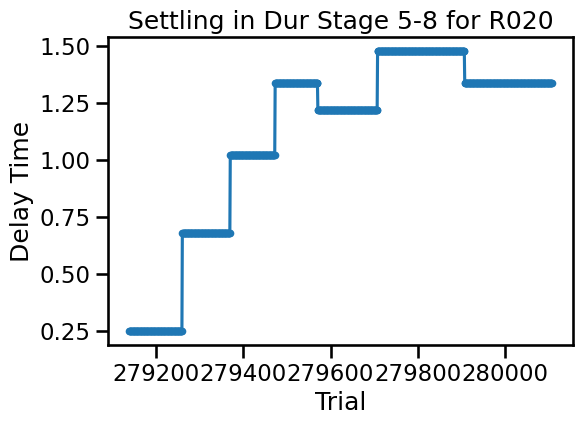

In [225]:
single_animal = "R020"
subdf = df.query("animal_id == @single_animal and stage >=5 and stage<8")
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(subdf.settling_in_dur, marker=".")
ax.set(
    ylabel="Delay Time",
    xlabel="Trial",
    title=f"Settling in Dur Stage 5-8 for {single_animal}",
)

[Text(0, 0.5, 'Delay Time'),
 Text(0.5, 0, 'Trial'),
 Text(0.5, 1.0, 'Pre Go Dur Stage 5-9 for R020')]

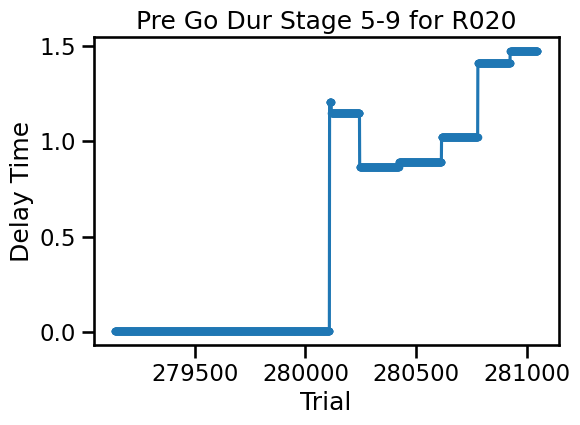

In [226]:
single_animal = "R020"
subdf = df.query("animal_id == @single_animal and stage >=5 and stage<9")
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(subdf.pre_go_dur, marker=".")

ax.set(
    ylabel="Delay Time",
    xlabel="Trial",
    title=f"Pre Go Dur Stage 5-9 for {single_animal}",
)

## Data Wrangling to do

List of things needed:
1. [X] Truncate at stage 11
2. [X] Subset columns- 
    > ['trial', 'animal_id', 'date', 'sess_id', 'hits', 'stage', 'sa', 'sb',
       'stimuli_on', 'settling_in_dur', 'legal_cbreak_dur', 'pre_dur',
       'adj_pre_dur', 'stimulus_dur', 'delay_dur', 'post_dur', 'sb_extra_dur'
       'viol_off_dur', 'pre_go_dur', 'sound_pair', 'give_type_imp', 'give_frac', 'n_settling_ins', 'avg_settling_in', 'cpoke_dur']
3. Session number relative to the start of stage 5 for each animal
4. [X]"fixation_dur" column that has stage specific logic 
   
    5. Stage 5-7, `fixation_dur = settling_in_dur`

    6. Stage 8, `fixation_dur = settling_in_dur + pre_go_dur`
    
    7. Stage 9-onwards `fixation_dur = pre_go_dur`



1. Reduce size of data frame by removing columns that are not needed and stages that are not needed

In [252]:
columns_of_interest = [
    "trial",
    "animal_id",
    "date",
    "sess_id",
    "hits",
    "violations",
    "stage",
    "sa",
    "sb",
    "stimuli_on",
    "settling_in_dur",
    "legal_cbreak_dur",
    "pre_dur",
    "adj_pre_dur",
    "stimulus_dur",
    "delay_dur",
    "post_dur",
    "sb_extra_dur",
    "viol_off_dur",
    "pre_go_dur",
    "sound_pair",
    "give_type_imp",
    "give_frac",
    "n_settling_ins",
    "avg_settling_in",
    "cpoke_dur",
]

tdf = df.query("stage >=5 and stage <= 11")[columns_of_interest].copy()

2. Make relative start date plots and count trials


In [253]:
tdf["date_time_date"] = pd.to_datetime(tdf["date"], format="%Y-%m-%d")
tdf["session"] = tdf.groupby("animal_id")["date_time_date"].transform(
    lambda x: (x - x.min()).dt.days + 1
)
tdf["cumulative_trial"] = tdf.groupby("animal_id").cumcount() + 1

2. Compute accutate fixation duration given stage requirements above

In [267]:
def determine_fixation_dur(row):
    if row["stage"] in (5, 6, 7, 8):
        if (
            row["session"] == 1 and row["cumulative_trial"] == 1
        ):  # pre go is sometimes set to 0.45
            return row.settling_in_dur
        else:
            return row.settling_in_dur + row.pre_go_dur
    elif row["stage"] >= 9:
        return row.pre_go_dur  # settling in dur now accounted for in pre_go_dur
    else:
        KeyError("Stage not found")


tdf["fixation_dur"] = tdf.apply(determine_fixation_dur, axis=1)

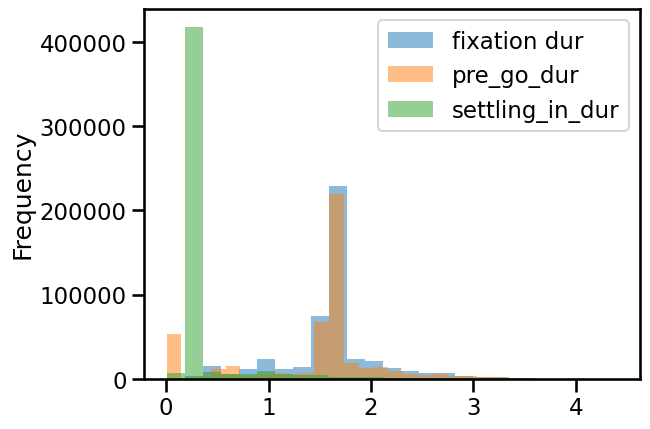

In [268]:
tdf.fixation_dur.plot(kind="hist", bins=25, label="fixation dur", alpha=0.5)
tdf.pre_go_dur.plot(kind="hist", bins=25, label="pre_go_dur", alpha=0.5)
tdf.settling_in_dur.plot(kind="hist", bins=25, label="settling_in_dur", alpha=0.5)
plt.legend()

Generally, fixation dur is quite similar to the pro go dur distribution. However, because it also includes settling in dur, it is a bit lower. Most trials happen in the 1.4-1.6 range as this is what occurs in stage 10, 11.

## Plots

* raw fixation dur over trials (focusing on stages 5-8)

* raw required vs actual dur over trials 

* fixation time max by session 

* number of sessions to 1.4s fixation

* violation rate by session to 1.5s fixation

    * pre stage 8 will be "retry_rate"

    * stage 8 onward will be "violation_rate"

* average violation rate early (stage 8)

* average violation rate late (stage 11 when there is no LG)

    * need to get count of trials for each animal here- might be a little messy


## Raw Data of delay over trials for each animal
    

In [231]:
subdf = tdf.query("animal_id == @single_animal and session <= 10")

[Text(0, 0.5, 'Delay Time'),
 Text(0.5, 0, 'Trial'),
 Text(0.5, 1.0, 'First 10 sessions for R020')]

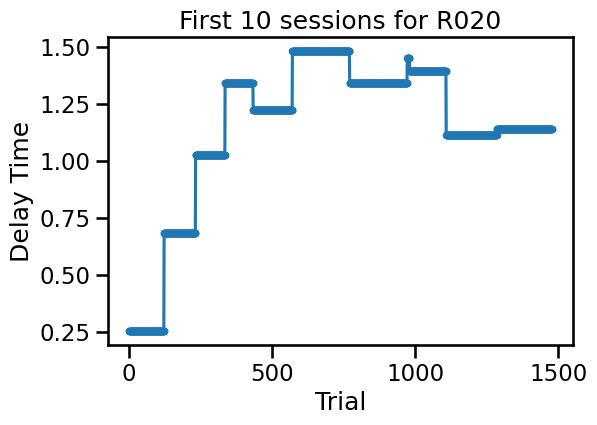

In [232]:
fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(subdf.cumulative_trial, subdf.fixation_dur, marker=".")

ax.set(
    ylabel="Delay Time", xlabel="Trial", title=f"First 10 sessions for {single_animal}"
)

[Text(0, 0.5, 'Delay Time'),
 Text(0.5, 0, 'Trial'),
 Text(0.5, 1.0, 'Sesion 10 for R020')]

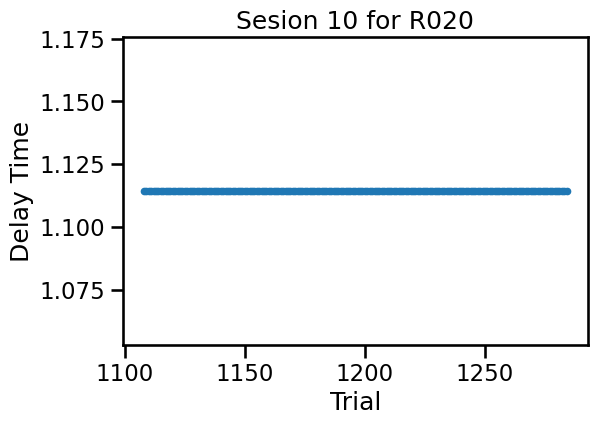

In [266]:
fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(
    subdf.query("session == 9").cumulative_trial,
    subdf.query("session == 9").fixation_dur,
    marker=".",
)

ax.set(ylabel="Delay Time", xlabel="Trial", title=f"Sesion 10 for {single_animal}")

## All Delay times over trials


Looking at only the first 50 sessions. Sometimes animals get set back into these earlier stages because of a rig switch or difficuluties with the sounds

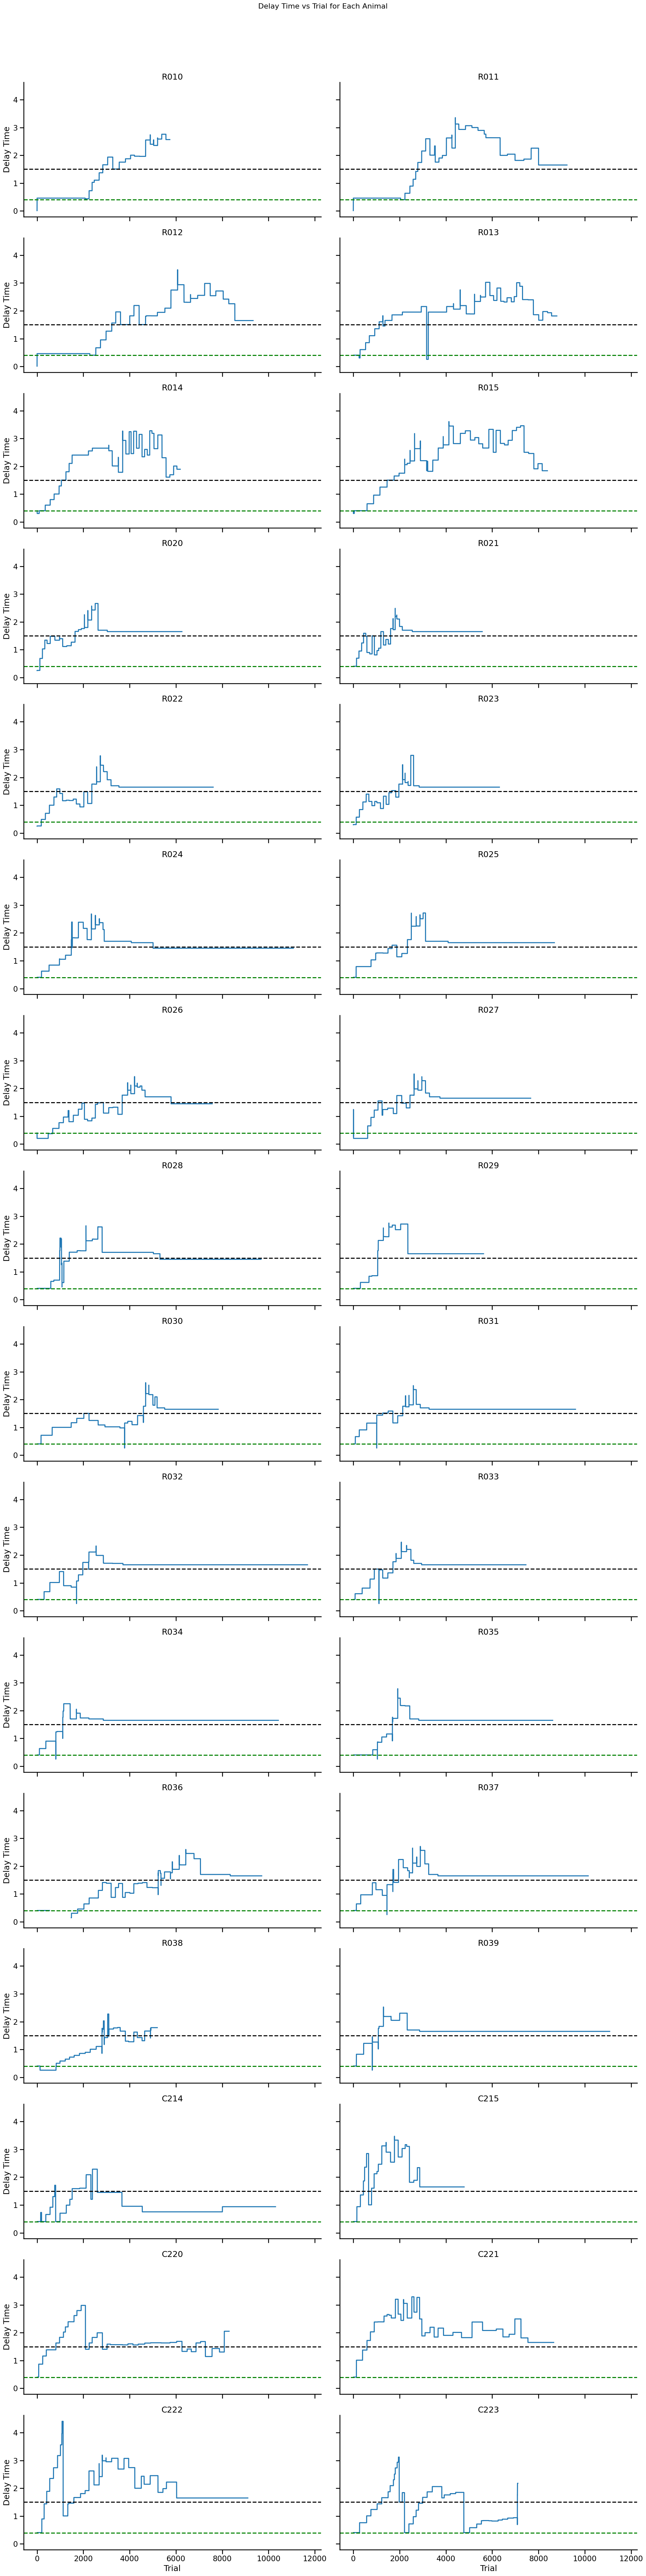

In [269]:
def matplolib_plot(x, y, **kwargs):
    plt.plot(x, y, **kwargs)


# Create a FacetGrid with 2 columns
g = sns.FacetGrid(
    tdf.query("session < 50"), col="animal_id", col_wrap=2, height=5, aspect=2
)

# Map the lineplot function to each subset of the data
g.map(matplolib_plot, "cumulative_trial", "fixation_dur")
g.map(plt.axhline, y=1.5, color="k", linestyle="--")
g.map(plt.axhline, y=0.4, color="g", linestyle="--")


# Add titles and adjust layout if needed
g.set_titles(col_template="{col_name}")
g.fig.subplots_adjust(top=0.95)
g.fig.suptitle("Delay Time vs Trial for Each Animal", fontsize=16)
g.set_axis_labels("Trial", "Delay Time")

In looking at my trianing section code- a threshold of 1.3 or 1.4 would make the most since since once the animal itself pokes for 1.6 (actual time in cpoke, not the required time), then it becomes a random sampling of delay times which may or may not be greater than 1.5.

There are also some animals I want to have a double look at.

* R023 growth point reached bfore doing into random
* R036 performance- this aniaml got reset back to spoking for a few days
* animals that appeared to be dropped below 400:
    * R013, R014, R015 (very few trials!)
    * R020
    * R023
    * R022
    * R026
    * R027
    * R036
    * R038

NEXT: Code below can be used to see if animals dropped below 400 and for how maany trials/sessions

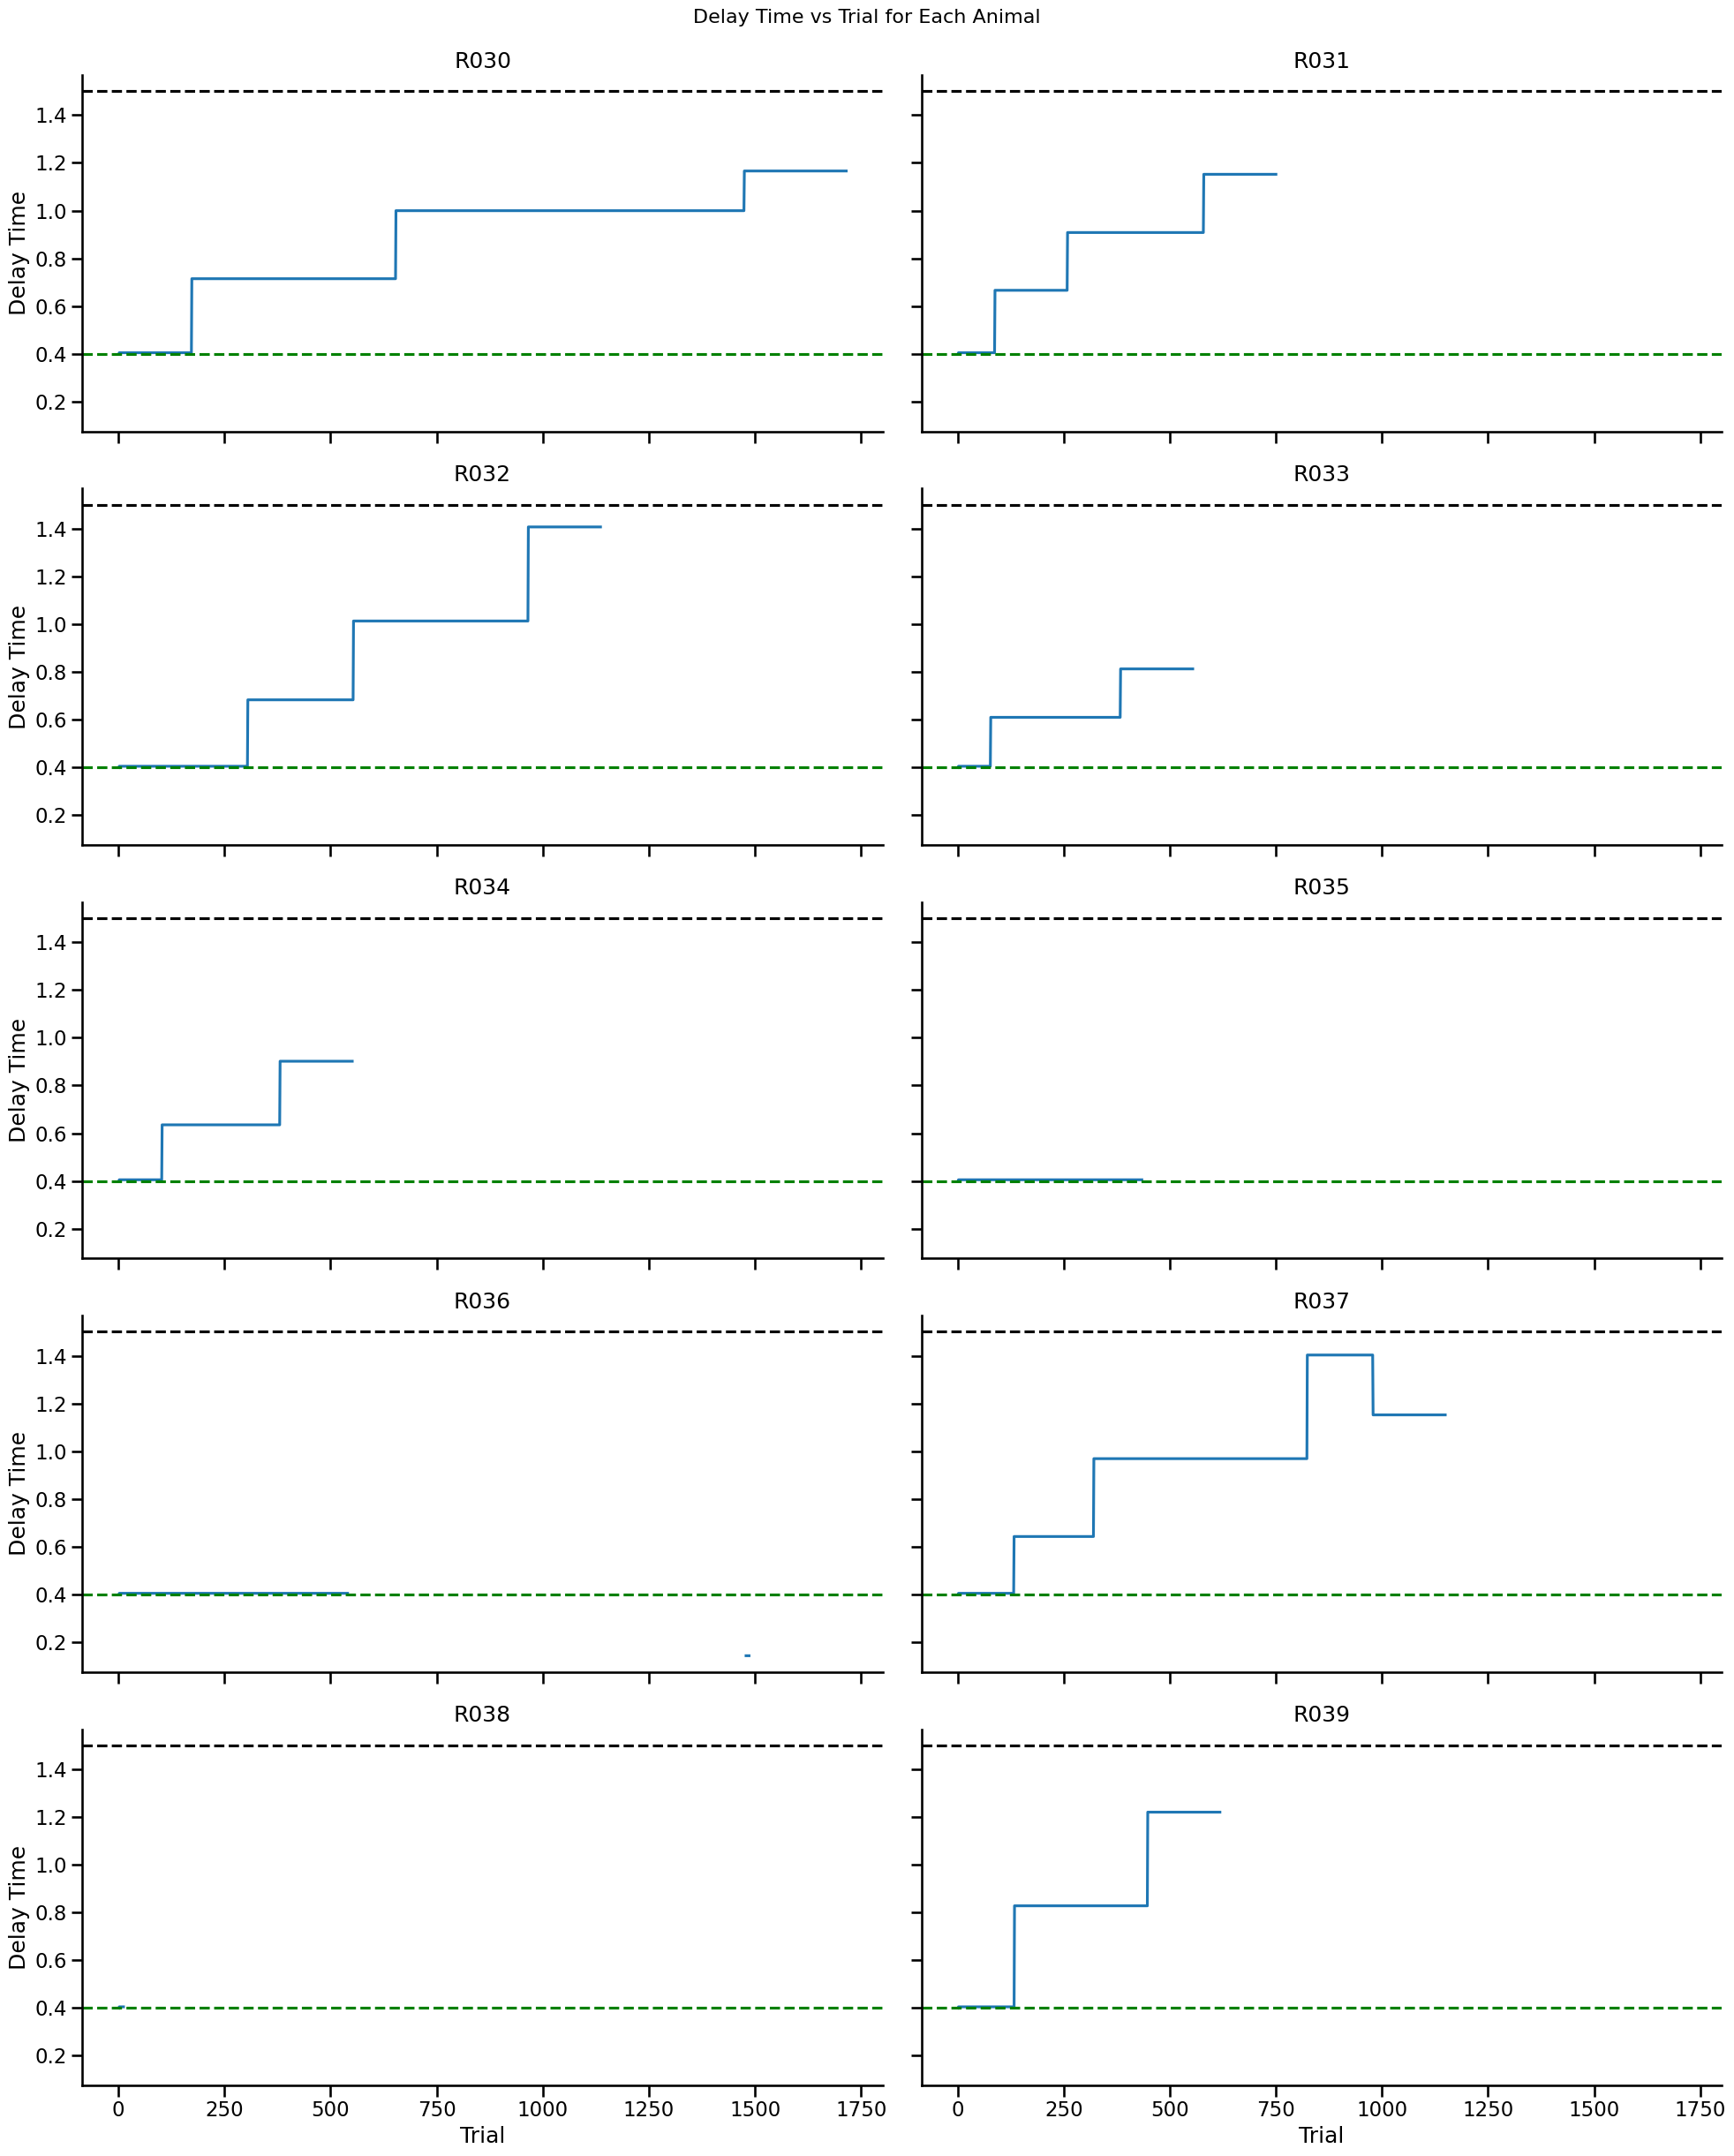

In [270]:
high_start = [ # switch to minimum_drop
    "R030",
    "R031",
    "R032",
    "R033",
    "R034",
    "R035",
    "R036",
    "R037",
    "R038",
    "R039",
]
session_max = 10
stage_max = 7


def matplolib_plot(x, y, **kwargs):
    plt.plot(x, y, **kwargs)


# Create a FacetGrid with 2 columns
g = sns.FacetGrid(
    tdf.query(
        "animal_id in @high_start and session < @session_max and stage < @stage_max"
    ),
    col="animal_id",
    col_wrap=2,
    height=5,
    aspect=2,
)

# Map the lineplot function to each subset of the data
g.map(matplolib_plot, "cumulative_trial", "fixation_dur")
g.map(plt.axhline, y=1.5, color="k", linestyle="--")
g.map(plt.axhline, y=0.4, color="g", linestyle="--")


# Add titles and adjust layout if needed
g.set_titles(col_template="{col_name}")
g.fig.subplots_adjust(top=0.95)
g.fig.suptitle("Delay Time vs Trial for Each Animal", fontsize=16)
g.set_axis_labels("Trial", "Delay Time")

In [247]:
tdf.query("animal_id=='R030'").iloc[0].fixation_dur

0.8500000000000001

In [200]:
tdf.columns

Index(['trial', 'animal_id', 'date', 'sess_id', 'hits', 'violations', 'stage',
       'sa', 'sb', 'stimuli_on', 'settling_in_dur', 'legal_cbreak_dur',
       'pre_dur', 'adj_pre_dur', 'stimulus_dur', 'delay_dur', 'post_dur',
       'sb_extra_dur', 'viol_off_dur', 'pre_go_dur', 'sound_pair',
       'give_type_imp', 'give_frac', 'n_settling_ins', 'avg_settling_in',
       'cpoke_dur', 'fixation_dur', 'date_time_date', 'session',
       'cumulative_trial'],
      dtype='object')

Dropping C214 since this animal is a clear outlier and making it difficult to interpret the plot. Also, I only want to look priot to stage 8.

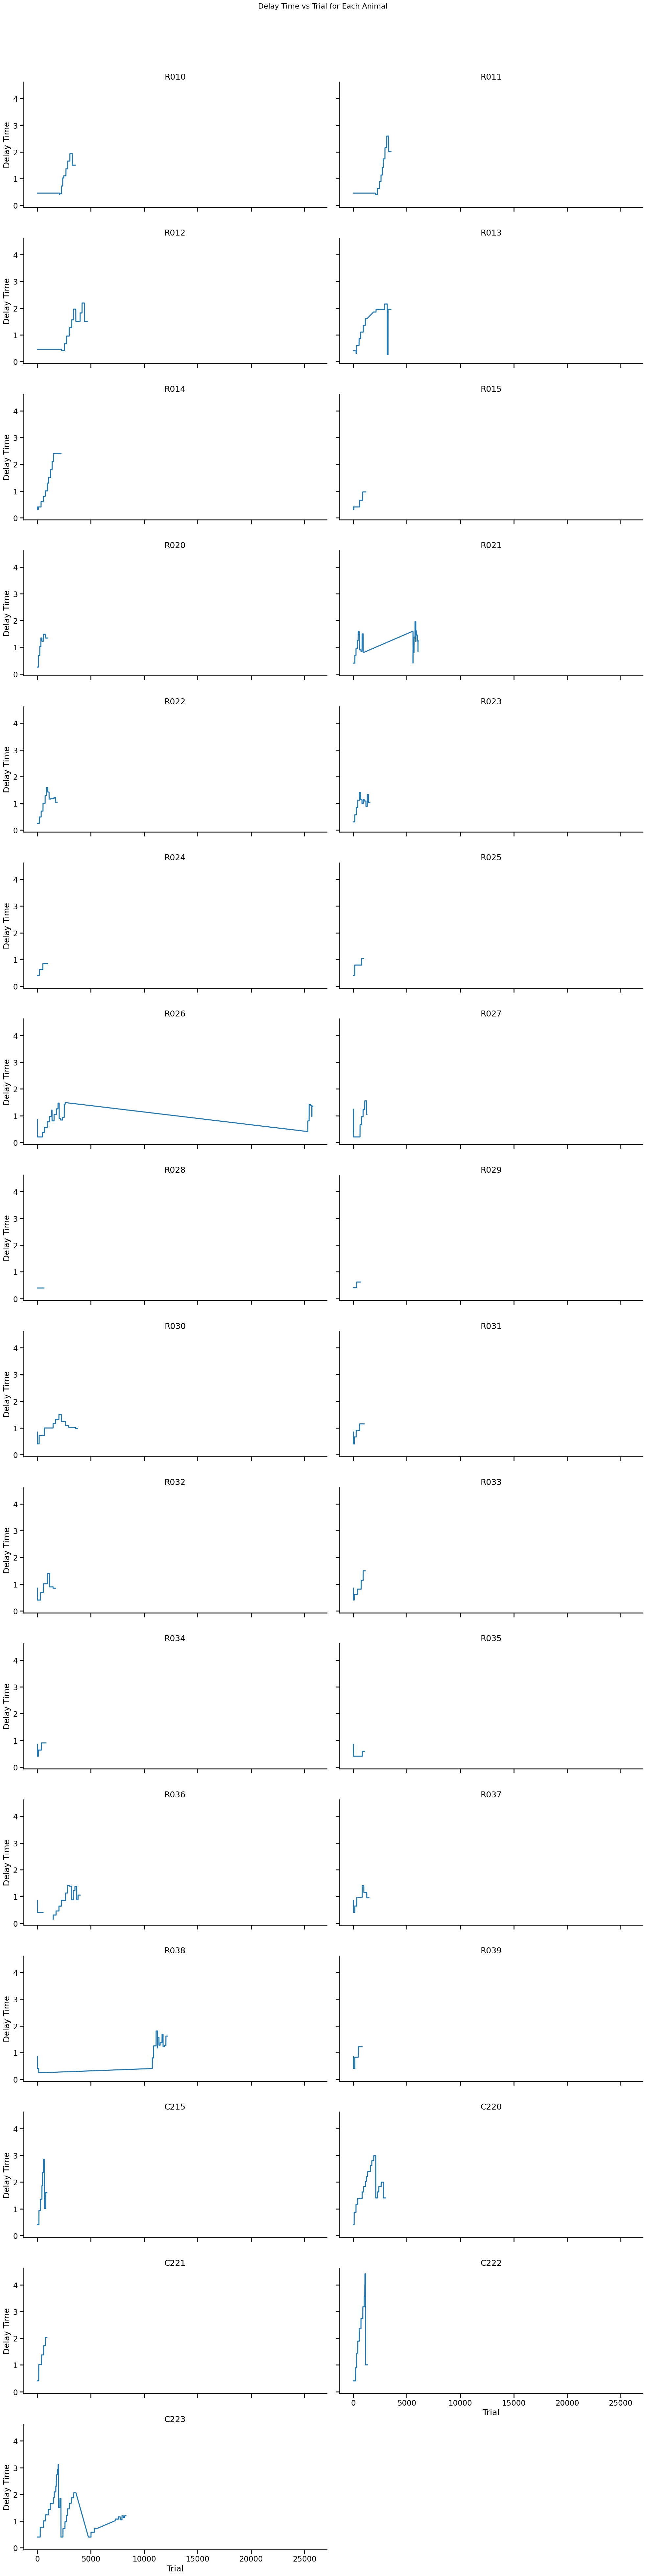

In [199]:
# Create a FacetGrid with 2 columns
g = sns.FacetGrid(
    tdf.query("animal_id != 'C214' and stage <8"),
    col="animal_id",
    col_wrap=2,
    height=5,
    aspect=2,
)

# Map the lineplot function to each subset of the data
g.map(matplolib_plot, "cumulative_trial", "fixation_dur")

# Add titles and adjust layout if needed
g.set_titles(col_template="{col_name}")
g.fig.subplots_adjust(top=0.95)
g.fig.suptitle("Delay Time vs Trial for Each Animal", fontsize=16)
g.set_axis_labels("Trial", "Delay Time")

In [184]:
def filter_sessions_up_to_threshold(df, threshold, col="delay_time"):
    """
    Filters the DataFrame to include all sessions for each animal leading up to (and including) the first session
    where the maximum delay_time is above the given threshold.

    Parameters:
    df (pd.DataFrame): DataFrame containing columns 'animal_id', 'session_id', 'trial', and 'delay_time'.
    threshold (float): The threshold above which we stop including sessions.

    Returns:
    pd.DataFrame: A filtered DataFrame containing sessions leading up to (and including) the first session
                  where the maximum delay_time is above the threshold for each animal.
    """
    # Step 1: Group by animal_id and session_id, and calculate the maximum delay_time for each session
    max_delay_time_per_session = (
        df.groupby(["animal_id", "session"])[col].max().reset_index()
    )

    dfs = []

    # Step 2: Iterate over each animal_id
    for animal_id, group in max_delay_time_per_session.groupby("animal_id"):
        # Step 3: Find the first session where the maximum delay_time is above the threshold
        above_threshold_session = group[group[col] > threshold]
        if not above_threshold_session.empty:
            first_above_threshold_session = above_threshold_session.iloc[0]["session"]

            print(
                f"animal_id = {animal_id}, above threshold session = {first_above_threshold_session}"
            )

            # Step 4: Grab all sessions to threshold and append
            dfs.append(
                df.query(
                    "animal_id == @animal_id and session <= @first_above_threshold_session"
                )
            )

    # Step 5: Filter the original DataFrame to include only the rows from the sessions to keep
    filtered_df = pd.concat(dfs, ignore_index=True)

    return filtered_df

In [185]:
threshold = 1.4
short_del_df = filter_sessions_up_to_threshold(
    tdf, threshold=threshold, col="fixation_dur"
)

animal_id = C214, above threshold session = 7
animal_id = C215, above threshold session = 14
animal_id = C220, above threshold session = 6
animal_id = C221, above threshold session = 5
animal_id = C222, above threshold session = 3
animal_id = C223, above threshold session = 5
animal_id = R010, above threshold session = 35
animal_id = R011, above threshold session = 21
animal_id = R012, above threshold session = 24
animal_id = R013, above threshold session = 6
animal_id = R014, above threshold session = 8
animal_id = R015, above threshold session = 8
animal_id = R020, above threshold session = 6
animal_id = R021, above threshold session = 5
animal_id = R022, above threshold session = 6
animal_id = R023, above threshold session = 13
animal_id = R024, above threshold session = 6
animal_id = R025, above threshold session = 8
animal_id = R026, above threshold session = 13
animal_id = R027, above threshold session = 10
animal_id = R028, above threshold session = 6
animal_id = R029, above thr

In [ ]:
# TODO for R010-12, drop the first pass through stages 1-3

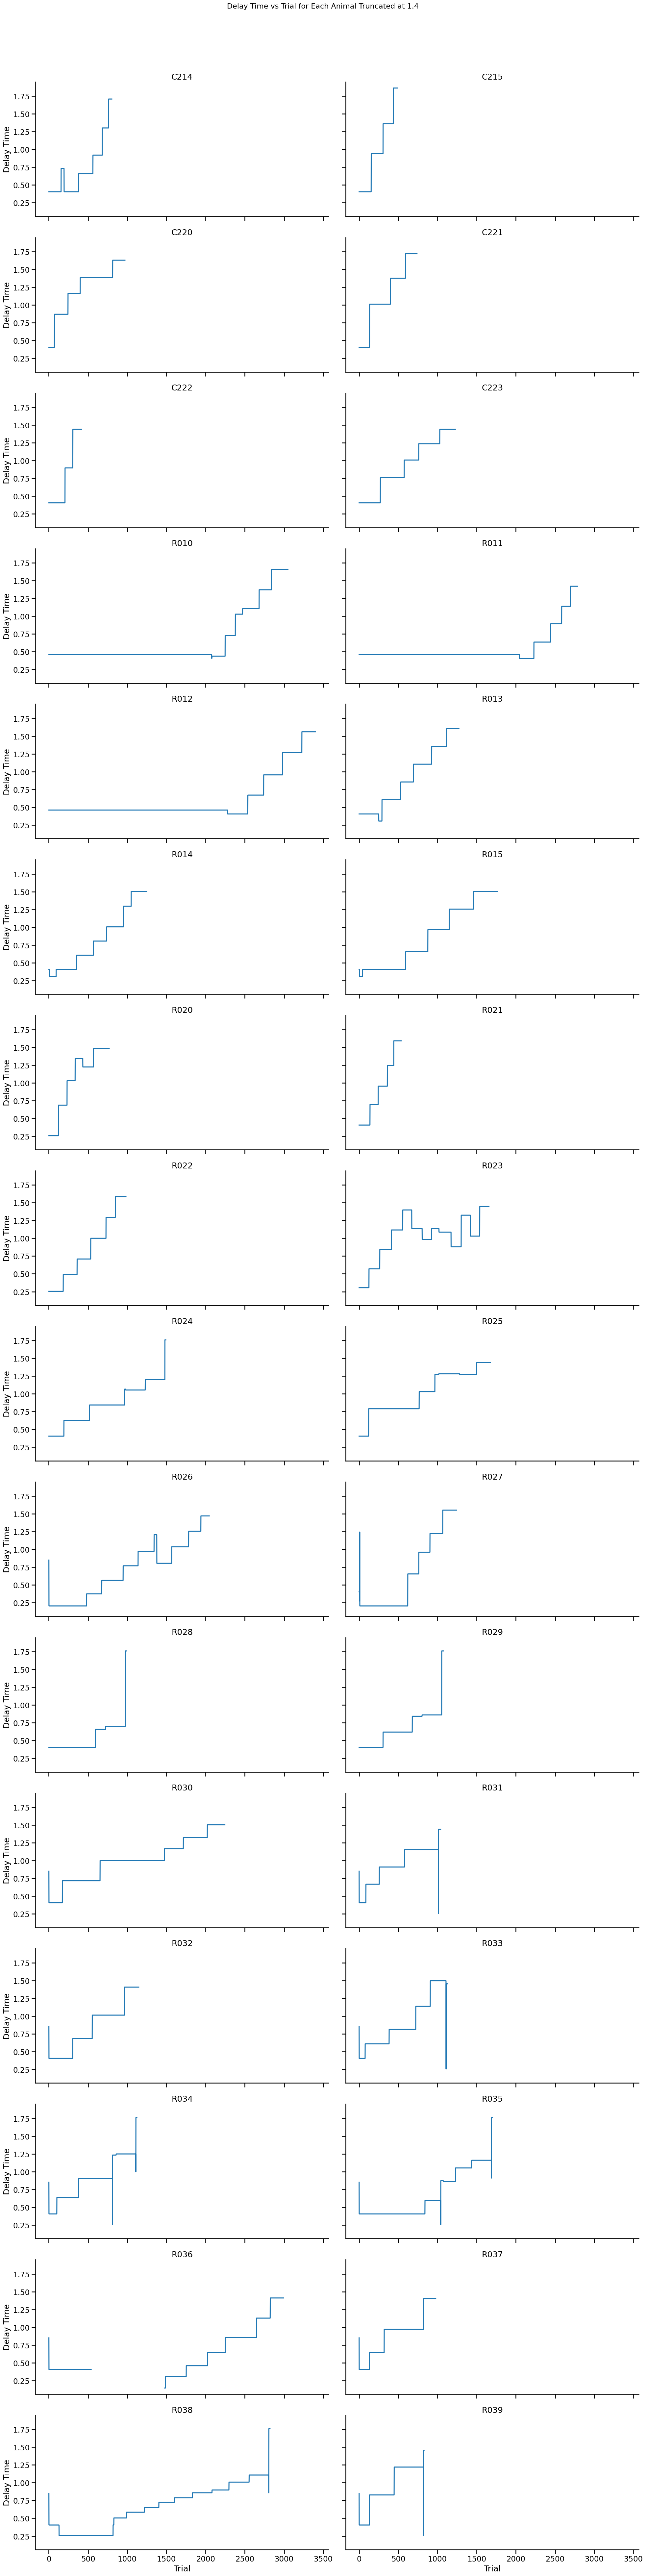

In [198]:
# Create a FacetGrid with 2 columns
g = sns.FacetGrid(
    short_del_df,
    col="animal_id",
    col_wrap=2,
    height=5,
    aspect=2,
)

# Map the lineplot function to each subset of the data
g.map(
    matplolib_plot,
    "cumulative_trial",
    "fixation_dur",
)

# Add titles and adjust layout if needed
g.set_titles(col_template="{col_name}")
g.fig.subplots_adjust(top=0.95)
g.fig.suptitle(
    f"Delay Time vs Trial for Each Animal Truncated at {threshold}", fontsize=16
)
g.set_axis_labels("Trial", "Delay Time")

In [ ]:
Next steps:
* session by delay time
* clean up R010-R012
* clean up R023
* double check R028?

### Violation Rates

Text(0.5, 1.0, 'Viol/Session Stages 8-11')

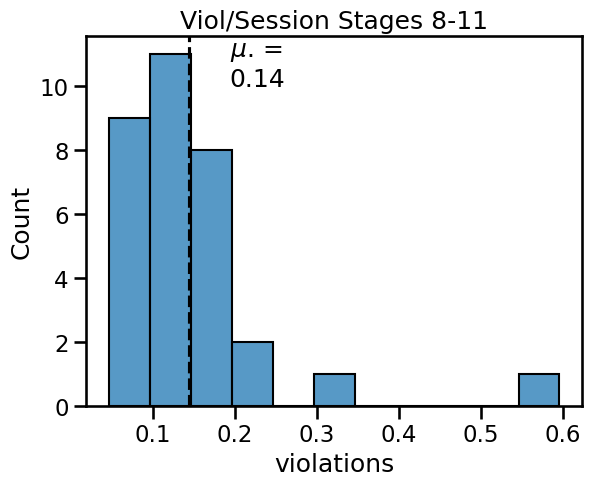

In [194]:
viol_by_session = (
    tdf.query("stage >= 8")
    .groupby(["animal_id", "sess_id"])
    .violations.mean()
    .groupby("animal_id")
    .mean()
).reset_index()

sns.histplot(data=viol_by_session, x="violations", bins=20, binwidth=0.05)

mean = viol_by_session.violations.mean()
plt.axvline(mean, color="k", linestyle="--")
plt.text(x=mean + 0.05, y=10, s=f"$\mu$. = \n{mean:.2f}")
plt.title("Viol/Session Stages 8-11")

In [195]:
tdf[tdf["fixation_dur"].isna()]

trial animal_id        date  sess_id  hits  violations  stage    sa   
729911      1      R036  2024-01-12   942935   1.0         0.0    5.0  12.0  \
729912      2      R036  2024-01-12   942935   1.0         0.0    5.0  12.0   
729913      3      R036  2024-01-12   942935   1.0         0.0    5.0  12.0   
729914      4      R036  2024-01-12   942935   1.0         0.0    5.0  12.0   
729915      5      R036  2024-01-12   942935   1.0         0.0    5.0   3.0   
...       ...       ...         ...      ...   ...         ...    ...   ...   
730844    373      R036  2024-01-13   943079   1.0         0.0    5.0   3.0   
730845    374      R036  2024-01-13   943079   1.0         0.0    5.0   3.0   
730846    375      R036  2024-01-13   943079   1.0         0.0    5.0   3.0   
730847    376      R036  2024-01-13   943079   1.0         0.0    5.0   3.0   
730848    377      R036  2024-01-13   943079   1.0         0.0    5.0   3.0   

          sb  stimuli_on  ...  sound_pair  give_type_imp  give_frac   
729911  12.0       False  ...  12.0, 12.0          light        1.0  \
729912  12.0       False  ...  12.0, 12.0          light        1.0   
729913  12.0       False  ...  12.0, 12.0          light        1.0   
729914  12.0       False  ...  12.0, 12.0          light        1.0   
729915   3.0       False  ...    3.0, 3.0          light        1.0   
...      ...         ...  ...         ...            ...        ...   
730844   3.0       False  ...    3.0, 3.0          light        1.0   
730845   3.0       False  ...    3.0, 3.0          light        1.0   
730846   3.0       False  ...    3.0, 3.0          light        1.0   
730847   3.0       False  ...    3.0, 3.0          light        1.0   
730848  12.0       False  ...   3.0, 12.0          light        1.0   

        n_settling_ins  avg_settling_in  cpoke_dur  fixation_dur   
729911             1.0              NaN        NaN           NaN  \
729912             1.0              NaN        NaN           NaN   
729913             1.0              NaN        NaN           NaN   
729914             1.0              NaN        NaN           NaN   
729915             1.0              NaN        NaN           NaN   
...                ...              ...        ...           ...   
730844             1.0              NaN     0.1478           NaN   
730845             1.0              NaN     0.0087           NaN   
730846             1.0              NaN     0.1036           NaN   
730847             1.0              NaN     0.1149           NaN   
730848             1.0              NaN     0.0741           NaN   

        date_time_date  session  cumulative_trial  
729911      2024-01-12        2               541  
729912      2024-01-12        2               542  
729913      2024-01-12        2               543  
729914      2024-01-12        2               544  
729915      2024-01-12        2               545  
...                ...      ...               ...  
730844      2024-01-13        3              1474  
730845      2024-01-13        3              1475  
730846      2024-01-13        3              1476  
730847      2024-01-13        3              1477  
730848      2024-01-13        3              1478  

[938 rows x 30 columns]

The error above is occurring due to the nans in the df for R036, we can drop those days I think.

## Raw Data of delay over trials for each animal

In [196]:
df.columns

Index(['trial', 'animal_id', 'date', 'sess_id', 'result', 'hits', 'violations',
       'temperror', 'hit_rate', 'error_rate', 'violation_rate',
       'temp_error_rate', 'n_lpokes', 'n_cpokes', 'n_rpokes', 'trial_dur',
       'trial_start', 'valid_early_spoke', 'first_spoke', 'first_lpoke',
       'first_rpoke', 'n_settling_ins', 'avg_settling_in', 'cpoke_dur',
       'stage', 'curriculum', 'sides', 'SMA_set', 'is_match', 'sa', 'sb',
       'stimuli_on', 'settling_in_dur', 'legal_cbreak_dur', 'pre_dur',
       'adj_pre_dur', 'stimulus_dur', 'delay_dur', 'post_dur', 'sb_extra_dur',
       'viol_off_dur', 'pre_go_dur', 'inter_trial_dur', 'go_type', 'go_dur',
       'give_type_set', 'give_type_imp', 'give_frac', 'give_delay_dur',
       'give_xtra_light_delay_dur', 'give_use', 'replay_on', 'timeouts',
       'water_delivered', 'give_water_not_drunk', 'crash_hist',
       'was_block_swtich', 'volume_multiplier', 'l_water_vol', 'r_water_vol',
       'ab_l_prob', 'ab_r_prob', 'ab_beta', 'ab_

In [197]:
single_animal = "W078"
subdf = df.query("animal_id == @single_animal and session < 10")
fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(subdf.delay_time, marker=".")

ax.set(
    ylabel="Delay Time", xlabel="Trial", title=f"First 10 sessions for {single_animal}"
)

UndefinedVariableError: name 'session' is not defined

[Text(0, 0.5, 'Delay Time'),
 Text(0.5, 0, 'Trial'),
 Text(0.5, 1.0, 'Sesion 10 for W078')]

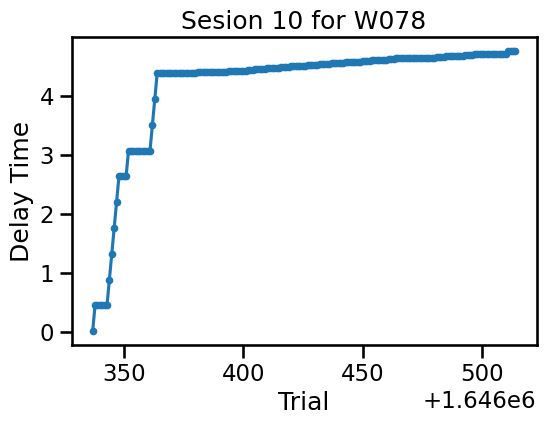

In [ ]:
single_animal = "W078"
subdf = df.query("animal_id == @single_animal and session == 10")
fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(subdf.delay_time, marker=".")

ax.set(ylabel="Delay Time", xlabel="Trial", title=f"Sesion 10 for {single_animal}")

## All delay times over trials in stage 1

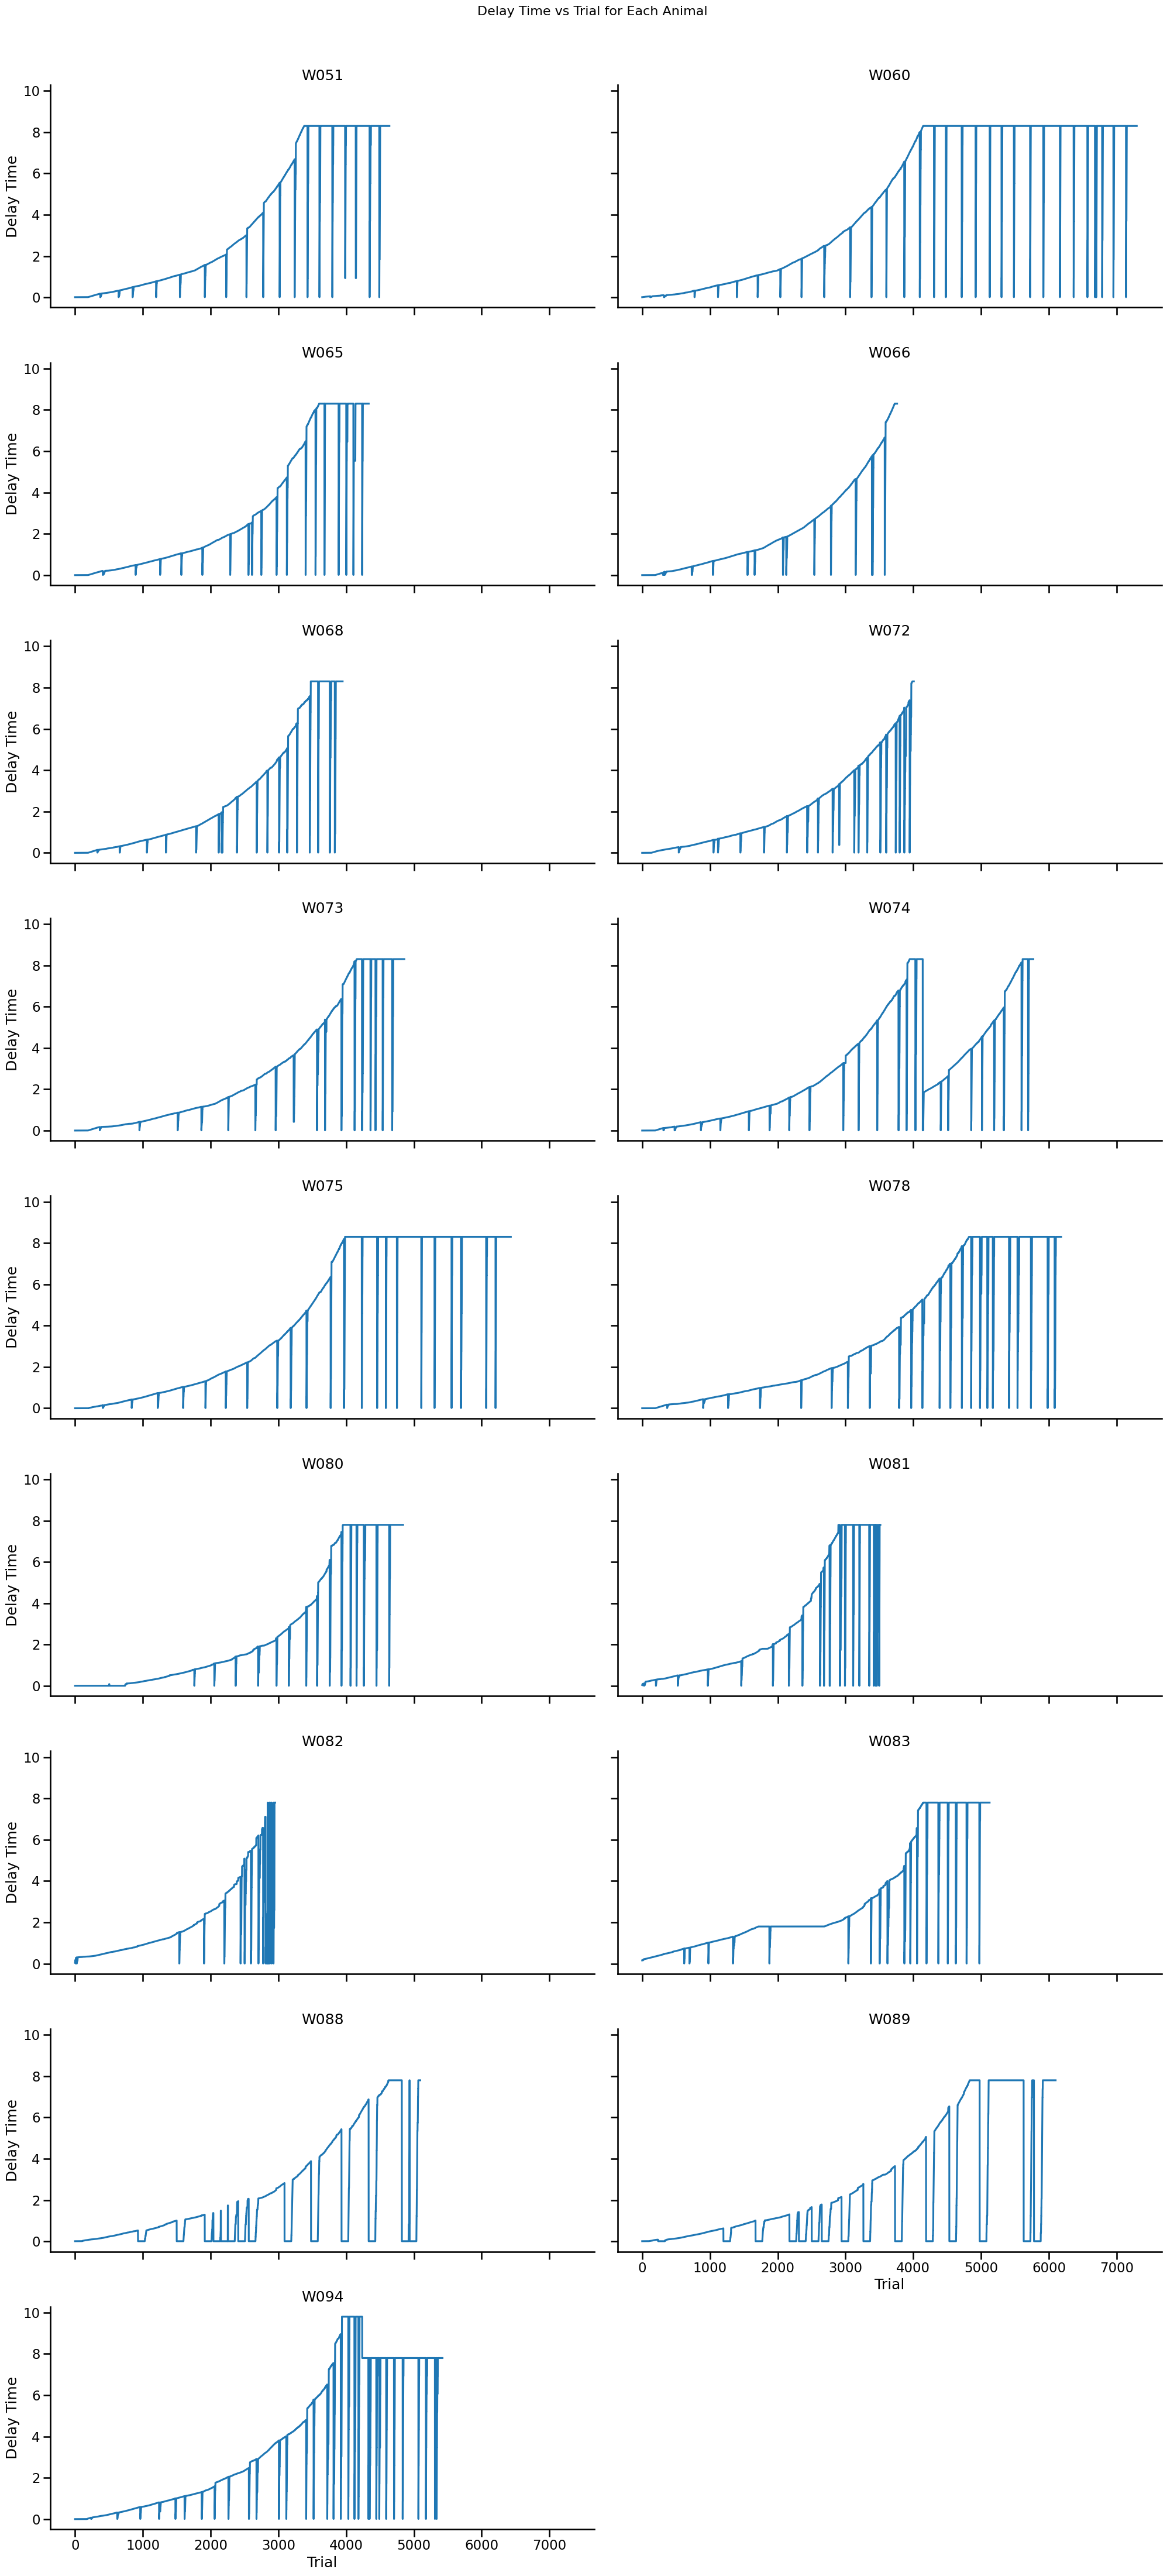

In [ ]:
def matplolib_plot(y, **kwargs):
    x = np.arange(len(y))
    plt.plot(x, y, **kwargs)


# Create a FacetGrid with 2 columns
g = sns.FacetGrid(
    df.query("training_stage == 1"), col="animal_id", col_wrap=2, height=5, aspect=2
)

# Map the lineplot function to each subset of the data
g.map(matplolib_plot, "delay_time")

# Add titles and adjust layout if needed
g.set_titles(col_template="{col_name}")
g.fig.subplots_adjust(top=0.95)
g.fig.suptitle("Delay Time vs Trial for Each Animal", fontsize=16)
g.set_axis_labels("Trial", "Delay Time")

## Repeat but for sessions with delay times less than 1.5 seconds

In [ ]:
def filter_sessions_by_delay_time(df, threshold):
    """
    Filters the DataFrame to only include sessions where the maximum delay_time is below the given threshold for each animal.

    Parameters:
    df (pd.DataFrame): DataFrame containing columns 'animal_id', 'session_id', 'trial', and 'delay_time'.
    threshold (float): The maximum allowed delay_time for a session to be included.

    Returns:
    pd.DataFrame: A filtered DataFrame containing only the rows where the maximum delay_time for the session is below the threshold.
    """
    # Step 1: Group by animal_id and session_id, and calculate the maximum delay_time for each session
    max_delay_time_per_session = (
        df.groupby(["animal_id", "session"])["delay_time"].max().reset_index()
    )

    # Step 2: Filter sessions where the maximum delay_time is below the threshold for each animal
    filtered_sessions = max_delay_time_per_session[
        max_delay_time_per_session["delay_time"] < threshold
    ]

    # Step 3: Filter the original DataFrame to only include rows from the filtered sessions for each animal
    filtered_df = df[
        df.set_index(["animal_id", "session"]).index.isin(
            filtered_sessions.set_index(["animal_id", "session"]).index
        )
    ]

    return filtered_df

In [ ]:
def filter_sessions_up_to_threshold(df, threshold):
    """
    Filters the DataFrame to include all sessions for each animal leading up to (and including) the first session
    where the maximum delay_time is above the given threshold.

    Parameters:
    df (pd.DataFrame): DataFrame containing columns 'animal_id', 'session_id', 'trial', and 'delay_time'.
    threshold (float): The threshold above which we stop including sessions.

    Returns:
    pd.DataFrame: A filtered DataFrame containing sessions leading up to (and including) the first session
                  where the maximum delay_time is above the threshold for each animal.
    """
    # Step 1: Group by animal_id and session_id, and calculate the maximum delay_time for each session
    max_delay_time_per_session = (
        df.groupby(["animal_id", "session"])["delay_time"].max().reset_index()
    )

    dfs = []

    # Step 2: Iterate over each animal_id
    for animal_id, group in max_delay_time_per_session.groupby("animal_id"):
        # Step 3: Find the first session where the maximum delay_time is above the threshold
        above_threshold_session = group[group["delay_time"] > threshold]
        if not above_threshold_session.empty:
            first_above_threshold_session = above_threshold_session.iloc[0]["session"]

            print(
                f"animal_id = {animal_id}, above threshold session = {first_above_threshold_session}"
            )

            # Step 4: Grab all sessions to threshold and append
            dfs.append(
                df.query(
                    "animal_id == @animal_id and session <= @first_above_threshold_session"
                )
            )

    # Step 5: Filter the original DataFrame to include only the rows from the sessions to keep
    filtered_df = pd.concat(dfs, ignore_index=True)

    return filtered_df

In [ ]:
threshold = 1.5
short_del_df = filter_sessions_up_to_threshold(df, threshold=threshold)

animal_id = W051, above threshold session = 6
animal_id = W060, above threshold session = 8
animal_id = W065, above threshold session = 6
animal_id = W066, above threshold session = 9
animal_id = W068, above threshold session = 6
animal_id = W072, above threshold session = 9
animal_id = W073, above threshold session = 6
animal_id = W074, above threshold session = 7
animal_id = W075, above threshold session = 7
animal_id = W078, above threshold session = 6
animal_id = W080, above threshold session = 7
animal_id = W081, above threshold session = 6
animal_id = W082, above threshold session = 7
animal_id = W083, above threshold session = 5
animal_id = W088, above threshold session = 6
animal_id = W089, above threshold session = 5
animal_id = W094, above threshold session = 9


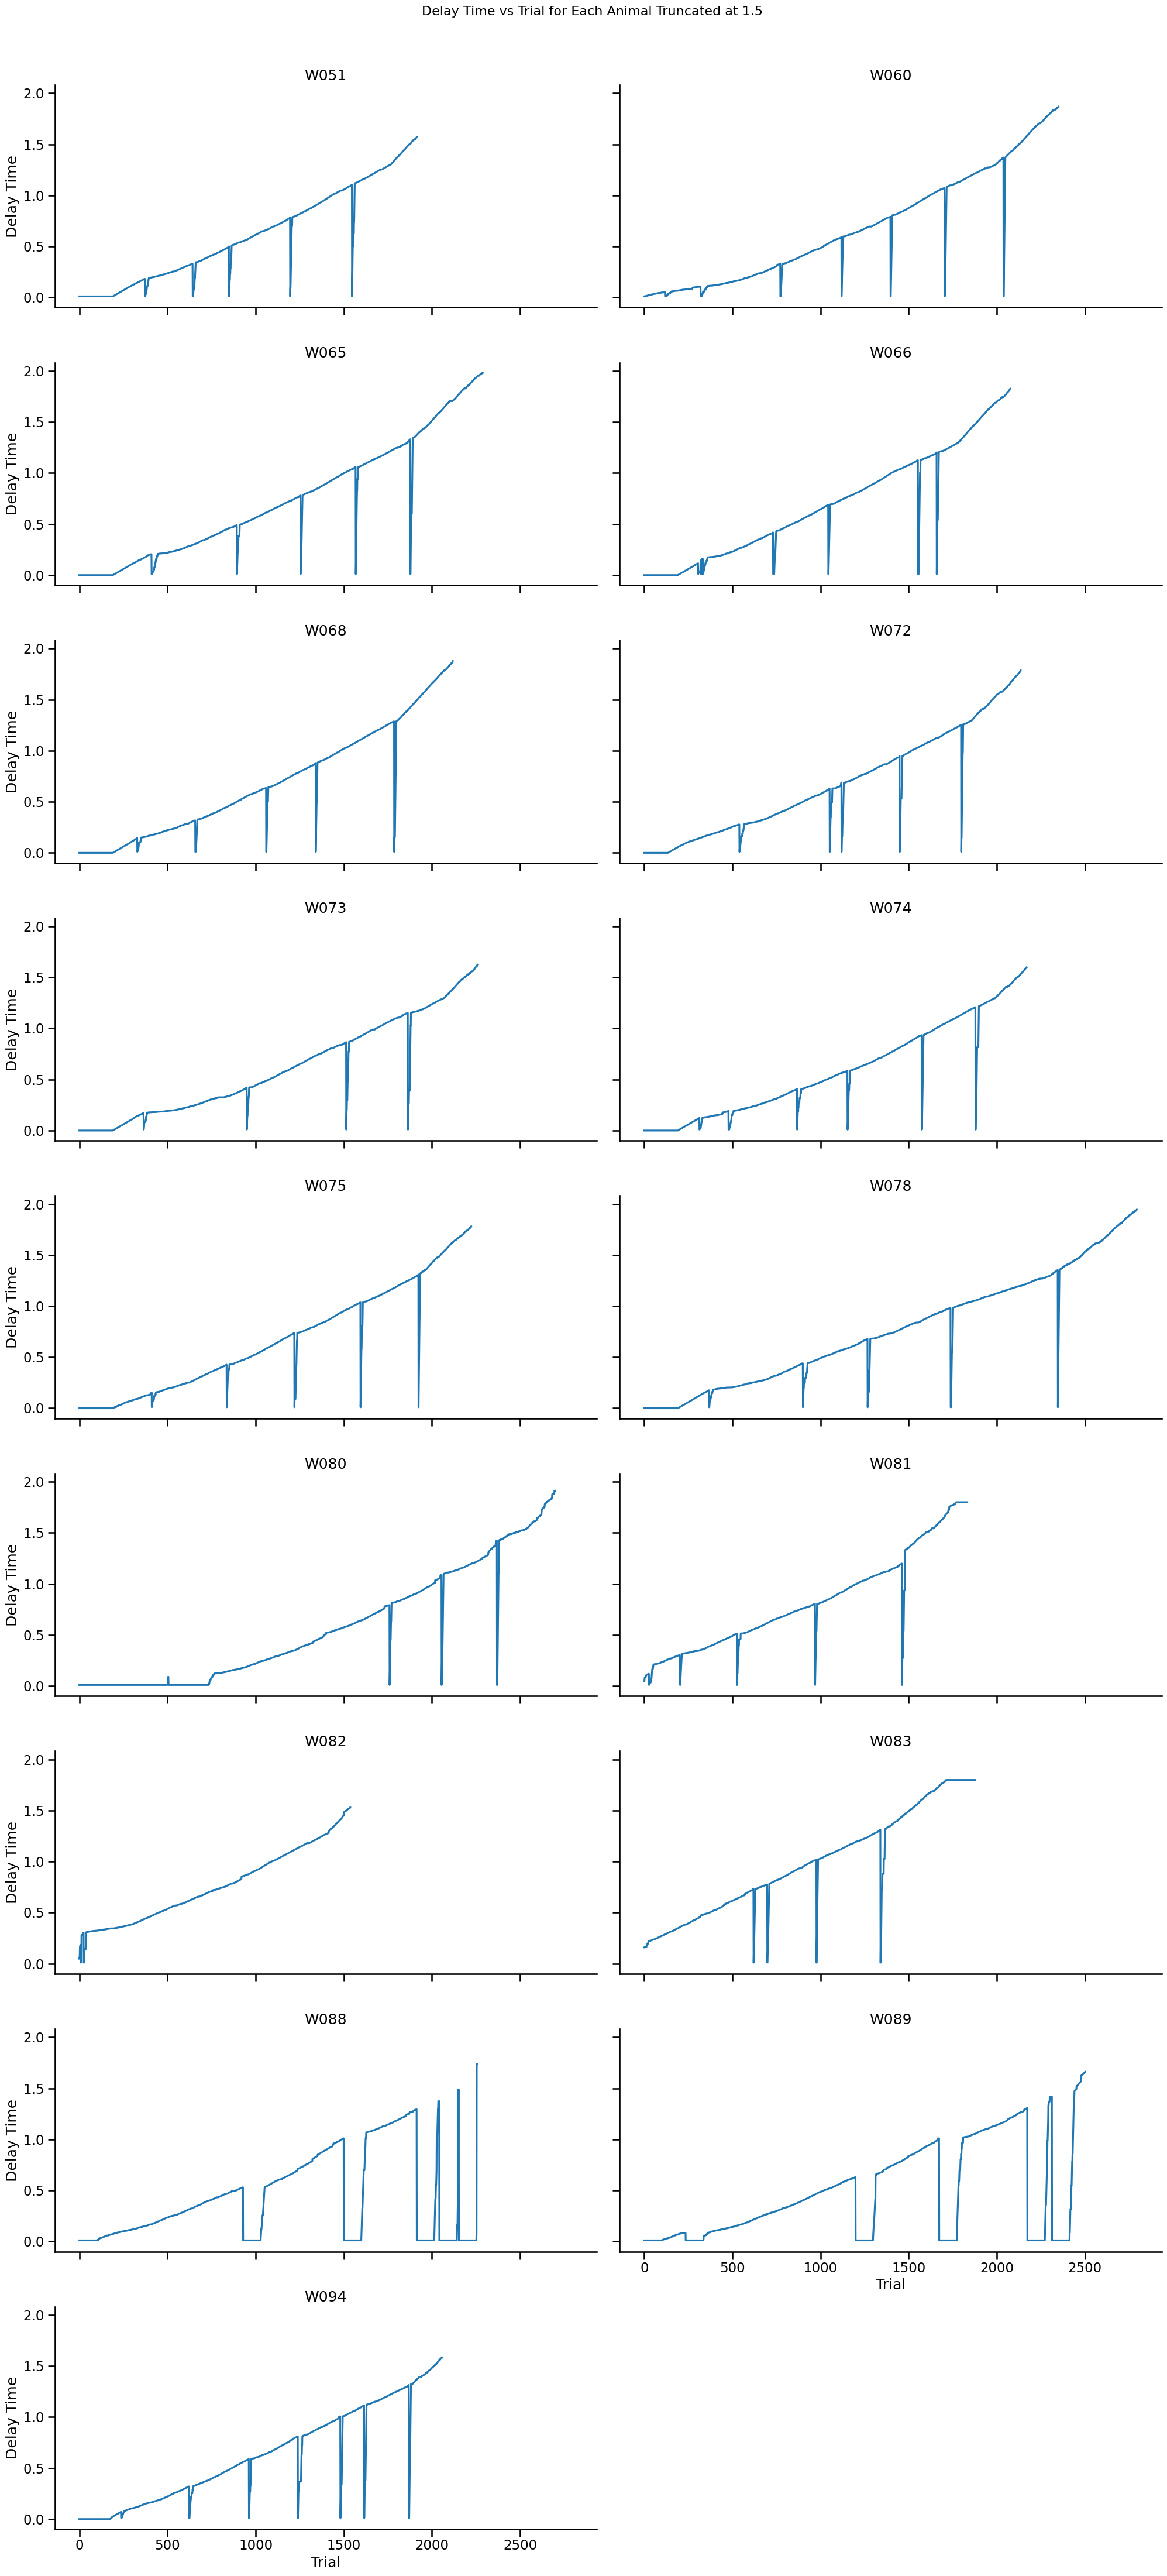

In [ ]:
# Create a FacetGrid with 2 columns
g = sns.FacetGrid(
    short_del_df.query("training_stage == 1"),
    col="animal_id",
    col_wrap=2,
    height=5,
    aspect=2,
)

# Map the lineplot function to each subset of the data
g.map(matplolib_plot, "delay_time")

# Add titles and adjust layout if needed
g.set_titles(col_template="{col_name}")
g.fig.subplots_adjust(top=0.95)
g.fig.suptitle(
    f"Delay Time vs Trial for Each Animal Truncated at {threshold}", fontsize=16
)
g.set_axis_labels("Trial", "Delay Time")

## Session by Delay Time (threshold at 1.5)



/var/folders/__/8jn6qz211155h1xb451s5zcr0000gn/T/ipykernel_50159/1913002043.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks())


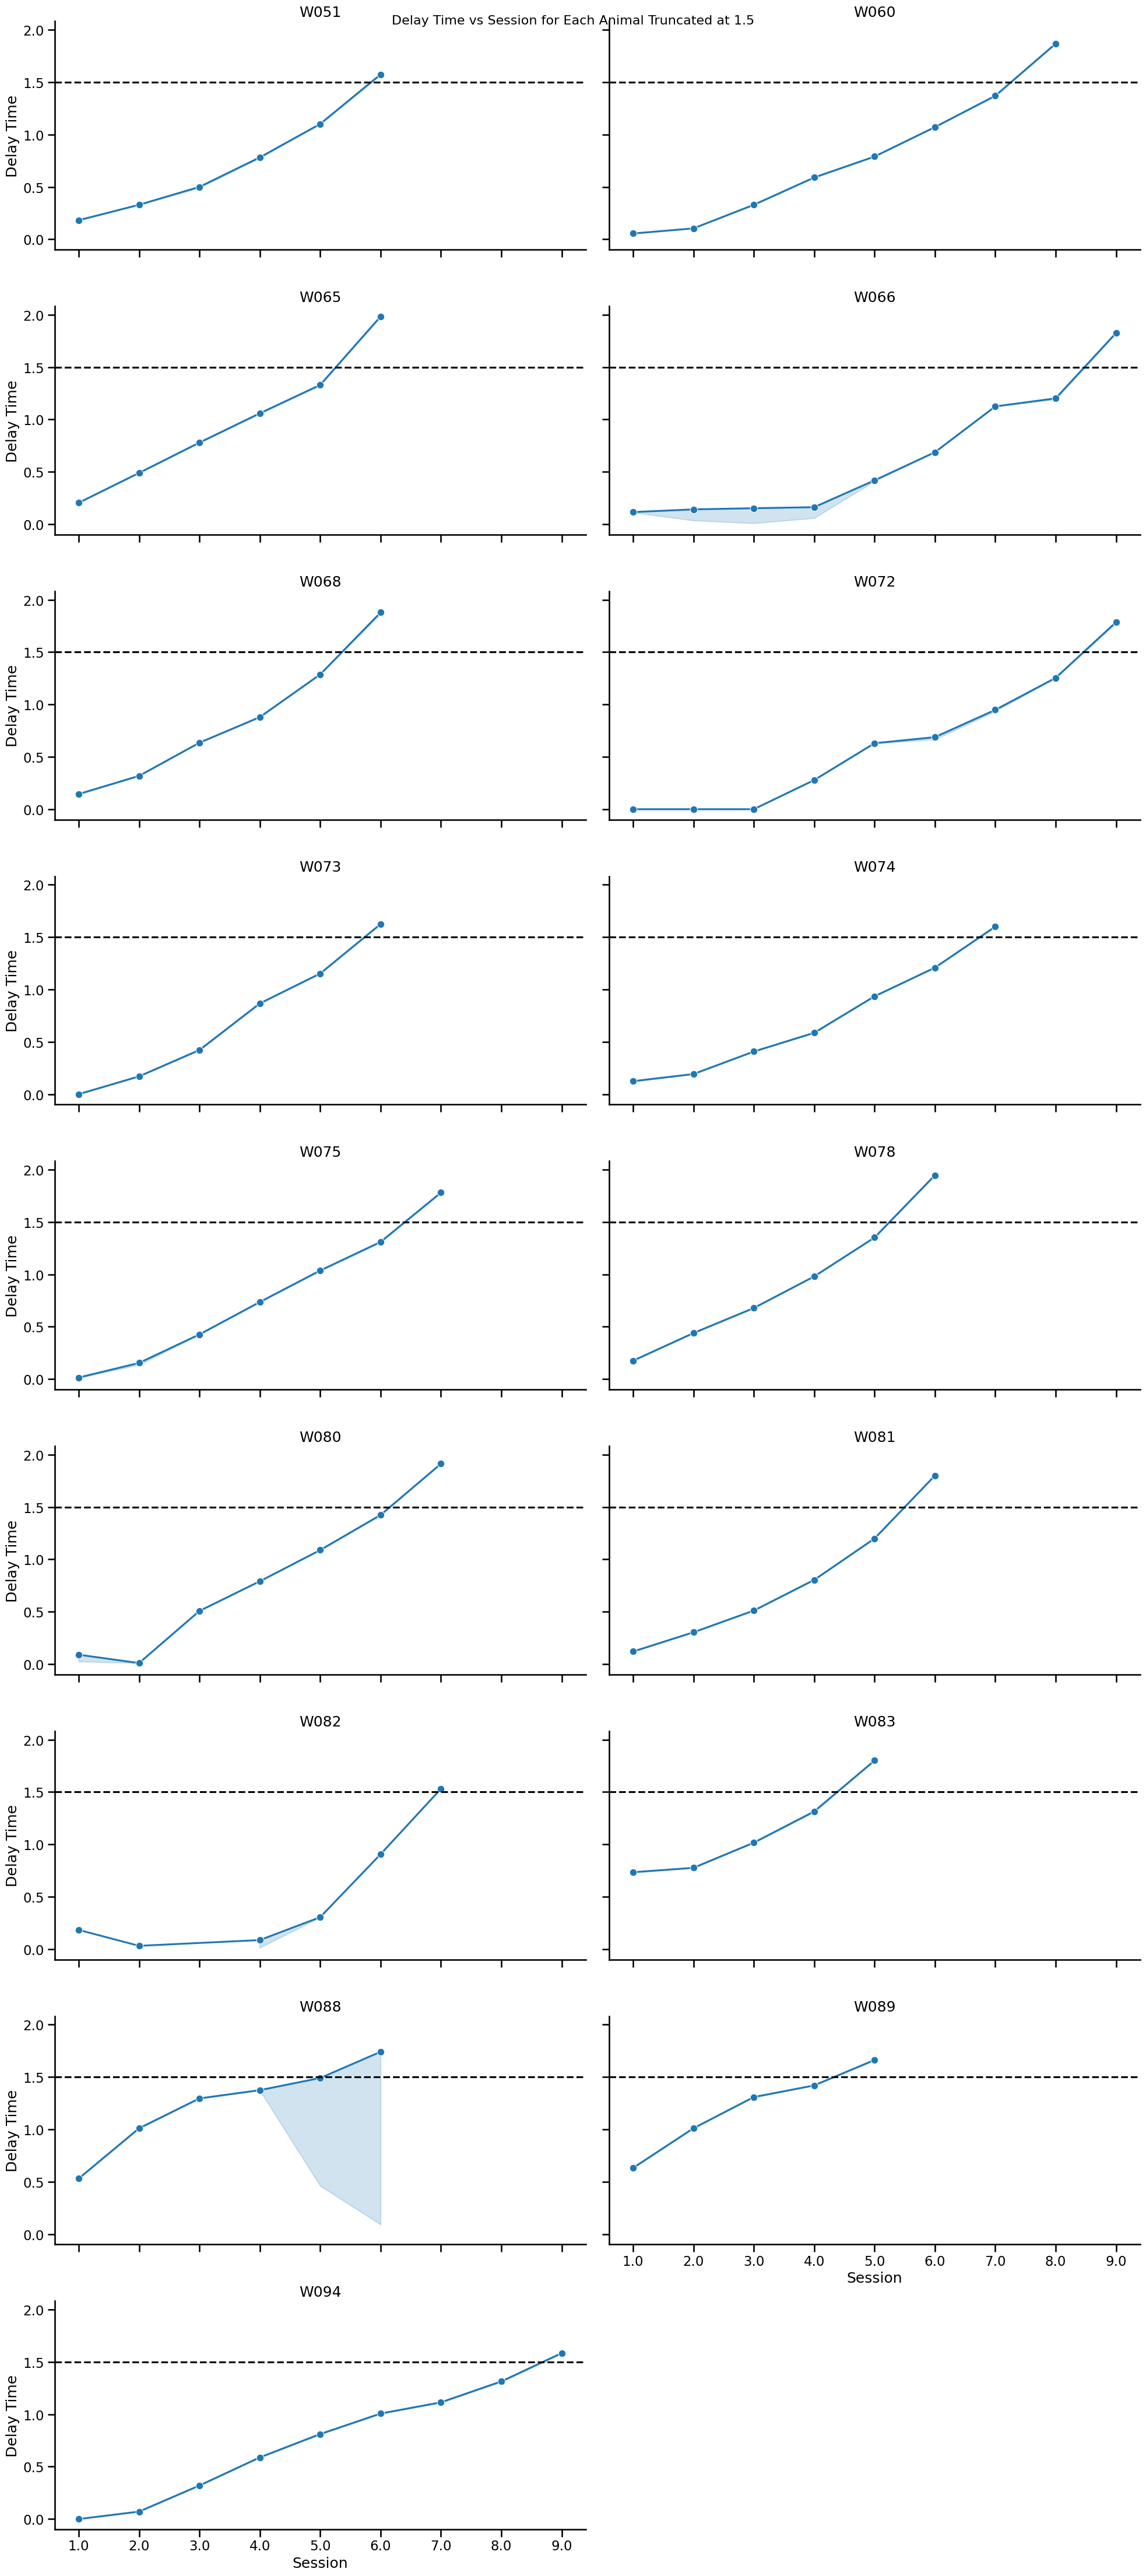

In [ ]:
# Create a FacetGrid with 2 columns
g = sns.FacetGrid(
    short_del_df.query("training_stage == 1"),
    col="animal_id",
    col_wrap=2,
    height=5,
    aspect=2,
)

# Map the lineplot function to each subset of the data
g.map(sns.lineplot, "session", "delay_time", marker="o", estimator="max")

# Add titles and adjust layout if needed
g.set_titles(col_template="{col_name}")
g.fig.subplots_adjust(top=0.95)
g.fig.suptitle(
    f"Delay Time vs Session for Each Animal Truncated at {threshold}", fontsize=16
)
g.set_axis_labels("Session", "Delay Time")

g.map(plt.axhline, y=1.5, color="k", linestyle="--")
for ax in g.axes.flatten():
    ax.set_xticklabels(ax.get_xticks())

## Number of sessions to reach 1.5s

In [ ]:
sess_to_gnp_thresh.session.mean()

6.764705882352941

Text(0.5, 1.0, 'Number of Sessions to 1.5s Fixation')

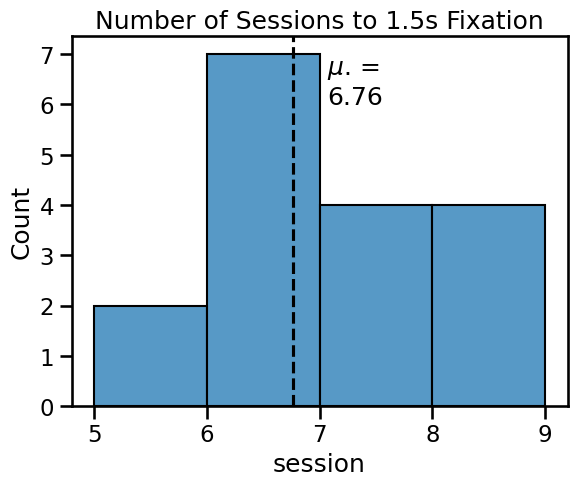

In [ ]:
sess_to_gnp_thresh = short_del_df.groupby("animal_id").session.max().reset_index()
sns.histplot(data=sess_to_gnp_thresh, x="session", binwidth=1)

mean = sess_to_gnp_thresh.session.mean()
plt.axvline(mean, color="k", linestyle="--")
plt.text(x=mean + 0.3, y=6, s=f"$\mu$. = \n{mean:.2f}")
plt.title("Number of Sessions to 1.5s Fixation")

In [ ]:
animals = sess_to_gnp_thresh.animal_id.nunique()
mean = sess_to_gnp_thresh.session.mean().round(2)
std = sess_to_gnp_thresh.session.std().round(2)
median = sess_to_gnp_thresh.session.median()

print(
    f"**Results** \nN animals = {animals}\n"
    f"Mean = {mean} +/- {std} std\n"
    f"Median = {median}"
)

**Results** 
N animals = 17
Mean = 6.76 +/- 1.3 std
Median = 6.0


## Violation Rates

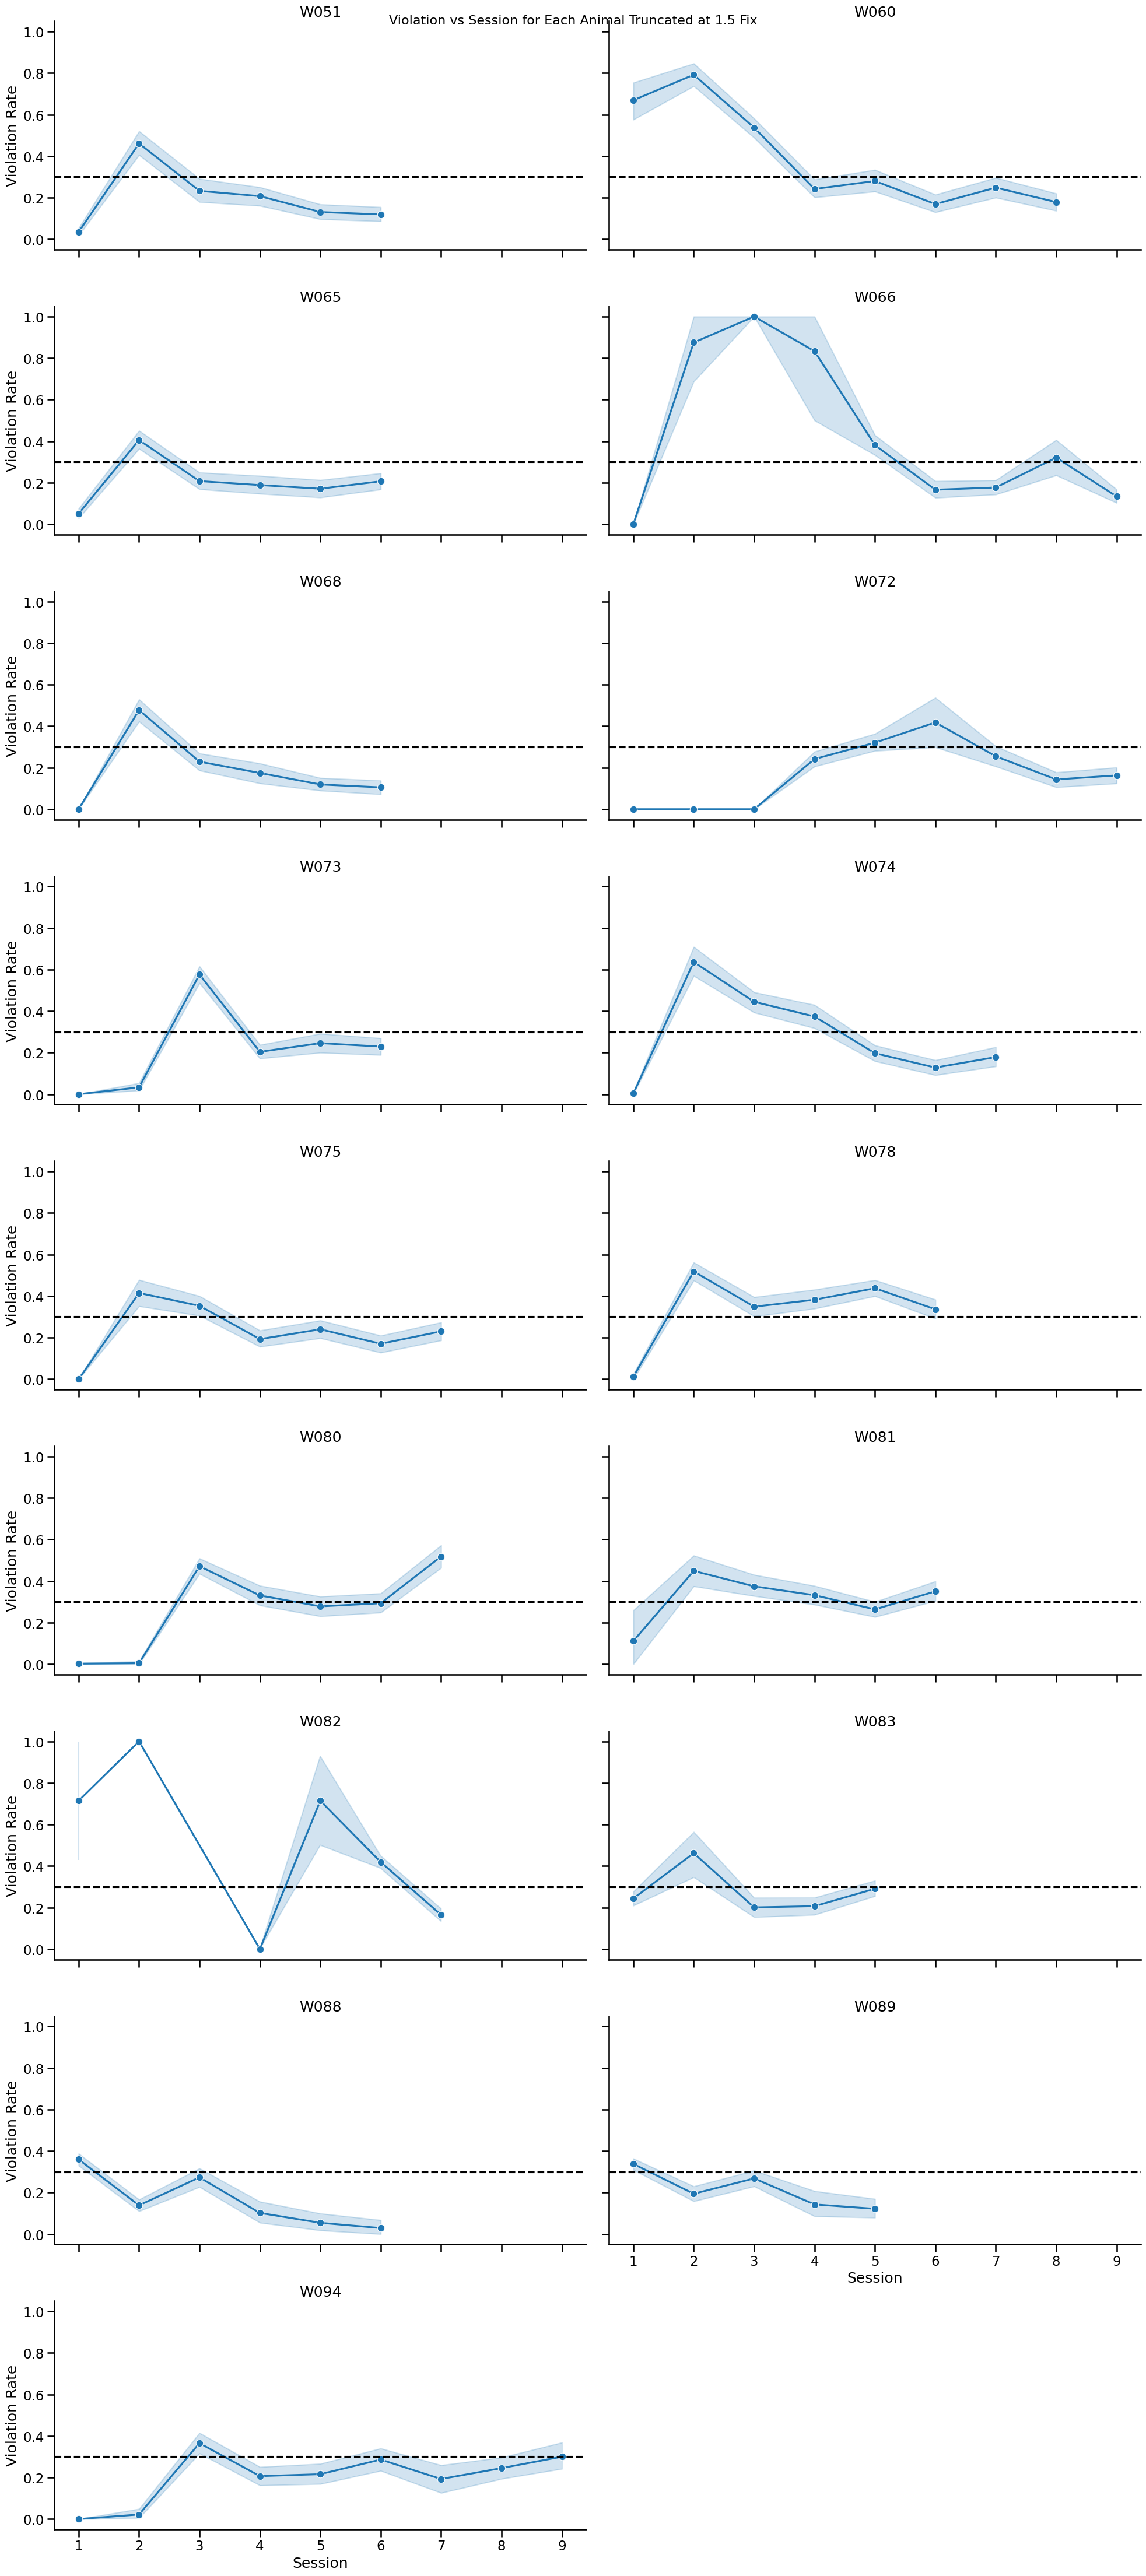

In [ ]:
# Create a FacetGrid with 2 columns
g = sns.FacetGrid(
    short_del_df,
    col="animal_id",
    col_wrap=2,
    height=5,
    aspect=2,
)

# Map the lineplot function to each subset of the data
g.map(sns.lineplot, "session", "violation", marker="o", estimator="mean")

# Add titles and adjust layout if needed
g.set_titles(col_template="{col_name}")
g.fig.subplots_adjust(top=0.95)
g.fig.suptitle(
    f"Violation vs Session for Each Animal Truncated at {threshold} Fix",
    fontsize=16,
)
g.set_axis_labels("Session", "Violation Rate")

g.map(plt.axhline, y=0.3, color="k", linestyle="--")

## Violation Rates

### Up to 1.5s Fixation

Text(0.5, 1.0, 'Viol/Session to 1.5s Fixation')

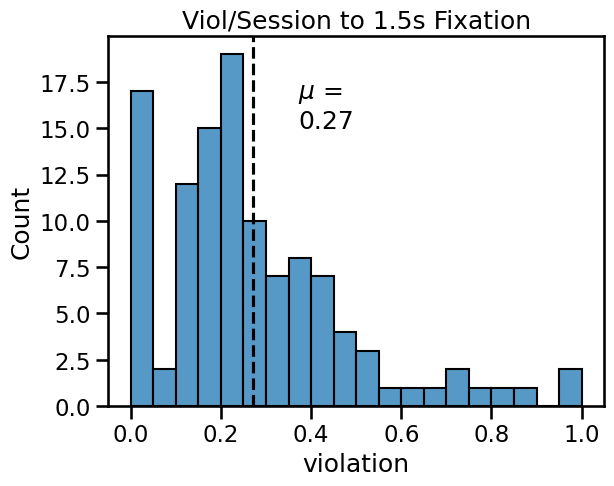

In [ ]:
viol_rates_to_thresh = (
    short_del_df.groupby(["animal_id", "session"]).violation.mean().reset_index()
)

plot_df = viol_rates_to_thresh
sns.histplot(data=plot_df, x="violation", bins=20, binwidth=0.05)

mean = plot_df.violation.mean()
plt.axvline(mean, color="k", linestyle="--")
plt.text(x=mean + 0.1, y=15, s=f"$\mu$ = \n{mean:.2f}")
plt.title("Viol/Session to 1.5s Fixation")

In [ ]:
animals = plot_df.animal_id.nunique()
mean = plot_df.violation.mean().round(2)
std = plot_df.violation.std().round(2)
median = plot_df.violation.median().round(2)

print(
    f"**Results** \nN animals = {animals}\n"
    f"Mean = {mean} +/- {std} std\n"
    f"Median = {median}"
)

**Results** 
N animals = 17
Mean = 0.27 +/- 0.21 std
Median = 0.23


Text(0.5, 1.0, 'Viol/Session Stage 4')

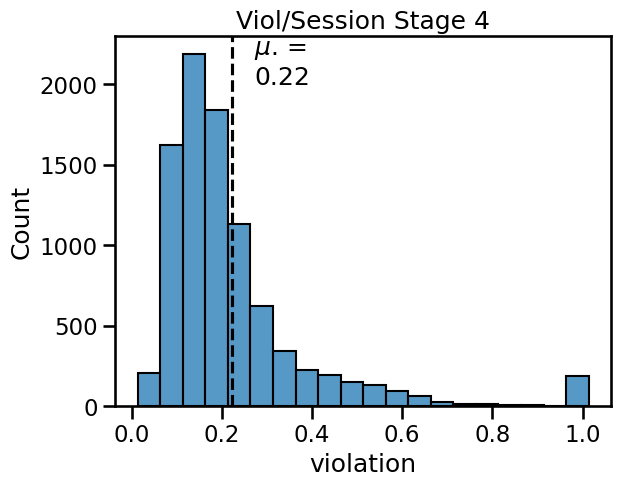

In [ ]:
viol_rates_stg_4 = (
    df.query("training_stage >=4")
    .groupby(["animal_id", "session"])
    .violation.mean()
    .reset_index()
)


plot_df = viol_rates_stg_4
sns.histplot(data=plot_df, x="violation", bins=20, binwidth=0.05)

mean = plot_df.violation.mean()
plt.axvline(mean, color="k", linestyle="--")
plt.text(x=mean + 0.05, y=2000, s=f"$\mu$. = \n{mean:.2f}")
plt.title("Viol/Session Stage 4")

In [ ]:
print(
    f"**Results** \nN animals = {animals}\n"
    f"Mean = {mean.round(2)} +/- {std} std\n"
    f"Median = {median}"
)

**Results** 
N animals = 17
Mean = 0.22 +/- 0.21 std
Median = 0.23


Text(0.5, 1.0, 'Viol/Session Stage 4')

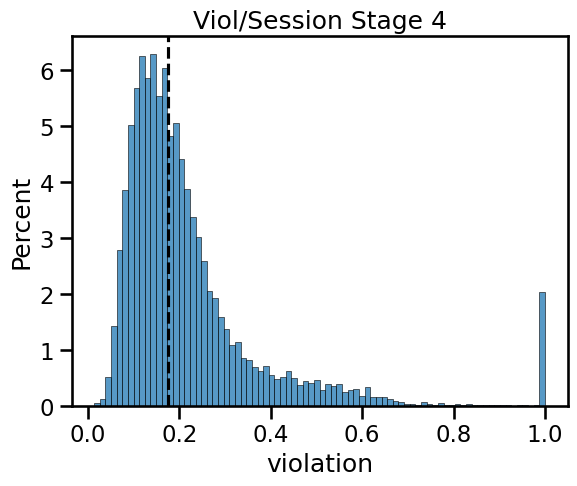

In [ ]:
sns.histplot(data=plot_df, x="violation", stat="percent")

median = plot_df.violation.median()
plt.axvline(median, color="k", linestyle="--")
# plt.text(x=median + 0.1, y=15, s=f"med. = \n{median:.2f}")
plt.title("Viol/Session Stage 4")

In [ ]:
### Relationship between 1.5 session avg fixation rate and stage 4 session avg fixation rate for each aniaml

In [ ]:
compare_viol_df = pd.DataFrame()
compare_viol_df["animal_id"] = df.animal_id.unique()

compare_viol_df["early_viol_rates"] = compare_viol_df["animal_id"].map(
    short_del_df.groupby(["animal_id", "session"])
    .violation.mean()
    .reset_index()
    .groupby("animal_id")
    .violation.mean()
)

compare_viol_df["late_viol_rates"] = compare_viol_df["animal_id"].map(
    df.query("training_stage >=4")
    .groupby(["animal_id", "session"])
    .violation.mean()
    .reset_index()
    .groupby("animal_id")
    .violation.mean()
)

compare_viol_df.head()

animal_id  early_viol_rates  late_viol_rates
0      W051          0.197887         0.154241
1      W060          0.389829         0.140485
2      W065          0.205036         0.377705
3      W066          0.431885         0.268015
4      W068          0.184107         0.207301

(0.1, 0.6)

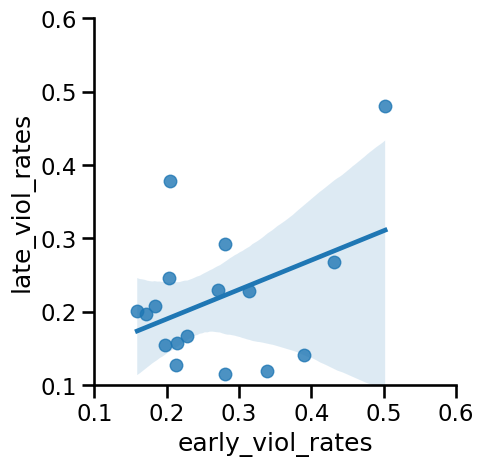

In [ ]:
sns.lmplot(data=compare_viol_df, x="early_viol_rates", y="late_viol_rates")

plt.xlim(0.1, 0.6)
plt.ylim(0.1, 0.6)

(0.1, 0.6)

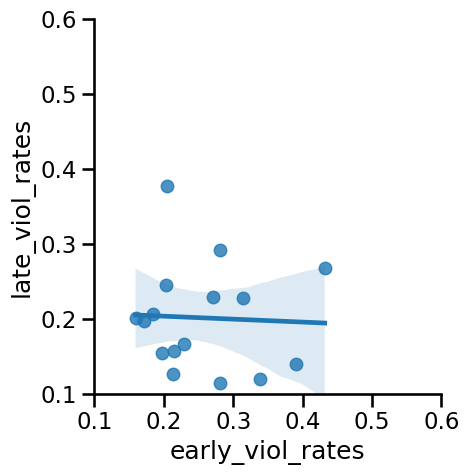

In [ ]:
sns.lmplot(
    data=compare_viol_df.query("animal_id != 'W082'"),
    x="early_viol_rates",
    y="late_viol_rates",
)

plt.xlim(0.1, 0.6)
plt.ylim(0.1, 0.6)

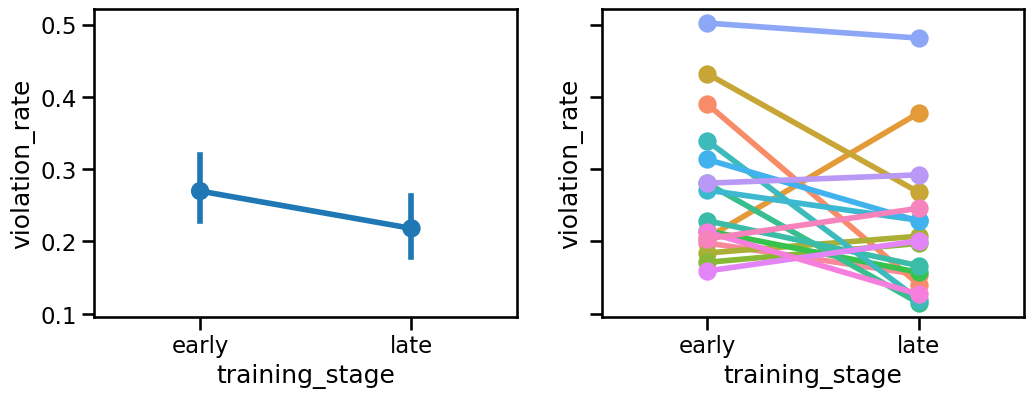

In [ ]:
melted_df = compare_viol_df.melt(
    id_vars="animal_id",
    value_vars=["early_viol_rates", "late_viol_rates"],
    var_name="training_stage",
    value_name="violation_rate",
)

melted_df["training_stage"] = melted_df.training_stage.replace(
    {"early_viol_rates": "early", "late_viol_rates": "late"}
)

fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
sns.pointplot(data=melted_df, x="training_stage", y="violation_rate", ax=ax[0])
sns.pointplot(
    data=melted_df, x="training_stage", y="violation_rate", hue="animal_id", ax=ax[1]
)

# remove legend
ax[1].get_legend().remove()